# 2.0 ACCESSIBILITY ASSESSMENT AND CLUSTERING

## EXPLORATORY DATA ANALYSIS (EDA)

### SECTION 1: Setup & Data Loading
- 1.1 Import libraries
- 1.2 Load Processed Data

### SECTION 2: Hospital Hierarchy Classification
- 2.1 Implement Healthcare System Hierarchy
- 2.2 Hierarchy Distribution Analysis
- 2.3 Regional Hierarchy Balance Assessment

### SECTION 3: Spatial Distribution Patterns
- 3.1 Healthcare Facility Distribution Analysis
- 3.2 Population Density Variations and Clustering
- 3.3 Malaria Incidence Spatial Patterns

### SECTION 4: Basic Spatial Relationships
- 4.1 Simple Distance Observations
- 4.2 Coverage Zone Visualization
- 4.3 Population-Facility Proximity Patterns

### SECTION 5: Visual Pattern Recognition
- 5.1 Geographic Distribution Patterns
- 5.2 Regional Pattern Analysis
- 5.3 Malaria Burden vs Healthcare Distribution

### SECTION 6: Statistical Summaries and Correlations
- 6.1 Descriptive Statistics Summary
- 6.2 Correlation Analysis
- 6.3 Regional Comparative Analysis

### SECTION 7: Data Quality and Validation
- 7.1 Spatial Data Integrity Checks
- 7.2 Data Completeness Assessment
- 3.3 Scale resolution to 1km

### SECTION 8: Key Findings and Research Implications
- 8.1 Primary Research Insights
- 8.2 Research Question Refinement
- 8.3 Methodology Implications


## SECTION 1: Setup & Data Loading

### __1.1 Import libraries__

In [1]:
#__1.2 Import libraries__

# Core data manipulation and analysis
import pandas as pd                       # For data manipulation and analysis
import numpy as np                        # For numerical computations

# Geospatial data handling
import geopandas as gpd                   # For handling geographic data and shapefiles
from geopandas.tools import sjoin         # For joining the grids to the boundary data
import rasterio                           # For reading and processing raster data (population, malaria)
from rasterio.features import rasterize
from rasterio.features import shapes
from rasterio.warp import calculate_default_transform, reproject, Resampling # For reprojecting rasters to target CRS
from rasterio.enums import Resampling     # For scaling the raster data pop and malaria data
import rasterio.mask                      # For define analysis region and clip rasters


# Visualization
import matplotlib.pyplot as plt           # For creating maps and visualisations
import seaborn as sns                     # For statistical visualisations
import colorcet as cc                     # for plotting the network with weights
from rasterio.plot import plotting_extent # plotting raster data
from matplotlib.colors import LogNorm     # For applying a logarithmic scale to color intensity in plots


# Spatial operations
from shapely.geometry import shape
from shapely.geometry import Polygon
from scipy.spatial.distance import cdist  # For spatial indexing and nearest neighbour searches
from scipy.spatial import cKDTree
from shapely.geometry import Point
from sklearn.cluster import KMeans        # For candidate location generation

# Network anaylsis
#import networkx as nx                     # For road network analysis and shortest path calculations
#import osmnx as ox                        # For downloading and processing OpenStreetMap road data

# others
#import os
print("library Loading complete")
print("-"*50)

library Loading complete
--------------------------------------------------


### __1.2 Load Processed Data__

In [2]:
# Load cleaned datasets from preprocessing notebook
exec(open('processed_data/load_data.py').read())

# Datasets loaded:
# - hospitals_cleaned: 2826 healthcare facilities  
# - pop_data_utm: Population grid (500x722, 1km resolution)
# - malaria_data_utm: Malaria incidence grid
# - regions_utm, districts_utm: Administrative boundaries

=== LOADING PROCESSED DATA ===
✅ All data loaded successfully!
Population grid: (722, 500)
Malaria grid: (722, 500)
Hospitals: 2826 facilities
CRS: EPSG:32630


In [3]:
# Drop 'Region' column and rename 'NAME_1' to 'Region'
hospitals_utm = hospitals_utm.drop('Region', axis=1).rename(columns={'NAME_1': 'Region'})

hospitals_utm

,OBJECTID,District,FacilityNa,Type,Town,Ownership,latitude,longitude,index_right,Region,x_utm,y_utm,geometry
0,1,Offinso North,A.M.E Zion Clinic,Clinic,Afrancho,CHAG,7.40801,-1.96317,1.0,Ashanti,614422.661515,8.189869e+05,POINT (614422.662 818986.851)
1,2,Bekwai Municipal,Abenkyiman Clinic,Clinic,Anwiankwanta,Private,6.46312,-1.58592,1.0,Ashanti,656373.862730,7.146165e+05,POINT (656373.863 714616.547)
2,3,Adansi North,Aboabo Health Centre,Health Centre,Aboabo No 2,Government,6.22393,-1.34982,1.0,Ashanti,682573.395292,6.882435e+05,POINT (682573.395 688243.477)
3,4,Afigya-Kwabre,Aboabogya Health Centre,Health Centre,Aboabogya,Government,6.84177,-1.61098,1.0,Ashanti,653484.490296,7.564788e+05,POINT (653484.49 756478.812)
4,5,Kwabre,Aboaso Health Centre,Health Centre,Aboaso,Government,6.84177,-1.61098,1.0,Ashanti,653484.490296,7.564788e+05,POINT (653484.49 756478.812)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2821,2838,Wassa-Amenfi West,Gravel Yard Clinic.,Clinic,Gravel Yard,Government,5.41941,-2.46114,14.0,Western,559696.252195,5.990521e+05,POINT (559696.252 599052.057)
2822,2839,Wassa-Amenfi West,St.Theresa Clinic,Clinic,Nope,CHAG,5.44135,-2.50321,14.0,Western,555033.522320,6.014734e+05,POINT (555033.522 601473.416)
2823,2840,Wassa-Amenfi West,Samartex Hospital,Hospital,Samreboi,Quasi-Government,5.61599,-2.56413,14.0,Western,548270.624598,6.207735e+05,POINT (548270.625 620773.526)
2824,2841,Shama Ahanta East,Infirmary Clinic,CHPS,Ping,Government,10.37467,-2.30288,12.0,Upper West,576313.848379,1.146921e+06,POINT (576313.848 1146921.405)


## SECTION 2: Hospital Hierarchy Classification

### __2.1 Implement Basic Healthcare System Hierarchy__

In [4]:
# 4-level classification 

def create_hospital_hierarchy(hospitals_df):
    """
    Create hierarchical classification for Ghana health facilities
    Based on Ghana health system pyramid structure
    
    Args:
        hospitals_df: DataFrame with healthcare facilities
    
    Returns:
        DataFrame with hierarchy classifications added
    """
    
    # Create copy to avoid modifying original data
    hospitals_hierarchical = hospitals_df.copy()
    
    # Define Ghana health system hierarchy mapping
    hierarchy_mapping = {
        # TERTIARY LEVEL (Level 4) - National referral centres
        'Teaching Hospital': 4,
        
        # SECONDARY LEVEL (Level 3) - Regional and district hospitals  
        'Regional Hospital': 3,
        'Hospital': 3,
        'District Hospital': 3,
        'Municipal Hospital': 3,
        'Metropolitan Hospital': 3,
        'Psychiatric Hospital': 3,  # Specialized secondary care
        'Polyclinic': 3,
        
        # PRIMARY LEVEL (Level 2) - Health centres and clinics
        'Health Centre': 2,
        'Clinic': 2,
        'Maternity Home': 2,
        'RCH': 2,  # Reproductive and Child Health
        'Centre': 2,  # Generic health centre
        
        # COMMUNITY LEVEL (Level 1) - Community-based services
        'CHPS': 1  # Community Health Planning and Services
    }
    
    # Level names for interpretation
    level_names = {
        4: 'Tertiary',
        3: 'Secondary', 
        2: 'Primary',
        1: 'Community',
        0: 'Unknown'  # For unclassified facilities
    }
    
    # Apply hierarchy classification
    hospitals_hierarchical['level_numeric'] = hospitals_hierarchical['Type'].map(
        lambda x: hierarchy_mapping.get(x, 0)  # Default to 0 for unknown types
    )
    
    hospitals_hierarchical['hierarchy_level'] = hospitals_hierarchical['level_numeric'].map(
        level_names
    )
    
    # Add service capacity weights (higher level = more capacity)
    capacity_weights = {4: 1.0, 3: 0.6, 2: 0.3, 1: 0.1, 0: 0.05}
    hospitals_hierarchical['capacity_weight'] = hospitals_hierarchical['level_numeric'].map(
        capacity_weights
    )
    
    print("✅ Hospital hierarchy classification complete")
    print(f"📊 Total facilities classified: {len(hospitals_hierarchical)}")
    
    return hospitals_hierarchical, hierarchy_mapping

# Apply hierarchy classification to your cleaned hospital data
hospitals_hierarchical, hierarchy_mapping = create_hospital_hierarchy(hospitals_utm)

✅ Hospital hierarchy classification complete
📊 Total facilities classified: 2826


In [4]:
# 4-level classification 

def create_hospital_hierarchy(hospitals_df):
    """
    Create hierarchical classification for Ghana health facilities
    Based on Ghana health system pyramid structure
    
    Args:
        hospitals_df: DataFrame with healthcare facilities
    
    Returns:
        DataFrame with hierarchy classifications added
    """
    
    # Create copy to avoid modifying original data
    hospitals_hierarchical = hospitals_df.copy()
    
    # Define Ghana health system hierarchy mapping
    hierarchy_mapping = {
        # TERTIARY LEVEL (Level 4) - National referral centres
        'Teaching Hospital': 4,
        
        # SECONDARY LEVEL (Level 3) - Regional and district hospitals  
        'Regional Hospital': 3,
        'Hospital': 3,
        'District Hospital': 3,
        'Municipal Hospital': 3,
        'Metropolitan Hospital': 3,
        'Psychiatric Hospital': 3,  # Specialized secondary care
        'Polyclinic': 3,
        
        # PRIMARY LEVEL (Level 2) - Health centres and clinics
        'Health Centre': 2,
        'Clinic': 2,
        'Maternity Home': 2,
        'RCH': 2,  # Reproductive and Child Health
        'Centre': 2,  # Generic health centre
        
        # COMMUNITY LEVEL (Level 1) - Community-based services
        'CHPS': 1  # Community Health Planning and Services
    }
    
    # Level names for interpretation
    level_names = {
        4: 'Tertiary',
        3: 'Secondary', 
        2: 'Primary',
        1: 'Community',
        0: 'Unknown'  # For unclassified facilities
    }
    
    # Apply hierarchy classification
    hospitals_hierarchical['level_numeric'] = hospitals_hierarchical['Type'].map(
        lambda x: hierarchy_mapping.get(x, 0)  # Default to 0 for unknown types
    )
    
    hospitals_hierarchical['hierarchy_level'] = hospitals_hierarchical['level_numeric'].map(
        level_names
    )
    
    # Add service capacity weights (higher level = more capacity)
    capacity_weights = {4: 1.0, 3: 0.6, 2: 0.3, 1: 0.1, 0: 0.05}
    hospitals_hierarchical['capacity_weight'] = hospitals_hierarchical['level_numeric'].map(
        capacity_weights
    )
    
    print("✅ Hospital hierarchy classification complete")
    print(f"📊 Total facilities classified: {len(hospitals_hierarchical)}")
    
    return hospitals_hierarchical, hierarchy_mapping

# Apply hierarchy classification to your cleaned hospital data
hospitals_hierarchical, hierarchy_mapping = create_hospital_hierarchy(hospitals_utm)

✅ Hospital hierarchy classification complete
📊 Total facilities classified: 2826


In [4]:
# 4-level classification 

def create_hospital_hierarchy(hospitals_df):
    """
    Create hierarchical classification for Ghana health facilities
    Based on Ghana health system pyramid structure
    
    Args:
        hospitals_df: DataFrame with healthcare facilities
    
    Returns:
        DataFrame with hierarchy classifications added
    """
    
    # Create copy to avoid modifying original data
    hospitals_hierarchical = hospitals_df.copy()
    
    # Define Ghana health system hierarchy mapping
    hierarchy_mapping = {
        # TERTIARY LEVEL (Level 4) - National referral centres
        'Teaching Hospital': 4,
        
        # SECONDARY LEVEL (Level 3) - Regional and district hospitals  
        'Regional Hospital': 3,
        'Hospital': 3,
        'District Hospital': 3,
        'Municipal Hospital': 3,
        'Metropolitan Hospital': 3,
        'Psychiatric Hospital': 3,  # Specialized secondary care
        'Polyclinic': 3,
        
        # PRIMARY LEVEL (Level 2) - Health centres and clinics
        'Health Centre': 2,
        'Clinic': 2,
        'Maternity Home': 2,
        'RCH': 2,  # Reproductive and Child Health
        'Centre': 2,  # Generic health centre
        
        # COMMUNITY LEVEL (Level 1) - Community-based services
        'CHPS': 1  # Community Health Planning and Services
    }
    
    # Level names for interpretation
    level_names = {
        4: 'Tertiary',
        3: 'Secondary', 
        2: 'Primary',
        1: 'Community',
        0: 'Unknown'  # For unclassified facilities
    }
    
    # Apply hierarchy classification
    hospitals_hierarchical['level_numeric'] = hospitals_hierarchical['Type'].map(
        lambda x: hierarchy_mapping.get(x, 0)  # Default to 0 for unknown types
    )
    
    hospitals_hierarchical['hierarchy_level'] = hospitals_hierarchical['level_numeric'].map(
        level_names
    )
    
    # Add service capacity weights (higher level = more capacity)
    capacity_weights = {4: 1.0, 3: 0.6, 2: 0.3, 1: 0.1, 0: 0.05}
    hospitals_hierarchical['capacity_weight'] = hospitals_hierarchical['level_numeric'].map(
        capacity_weights
    )
    
    print("✅ Hospital hierarchy classification complete")
    print(f"📊 Total facilities classified: {len(hospitals_hierarchical)}")
    
    return hospitals_hierarchical, hierarchy_mapping

# Apply hierarchy classification to your cleaned hospital data
hospitals_hierarchical, hierarchy_mapping = create_hospital_hierarchy(hospitals_utm)

✅ Hospital hierarchy classification complete
📊 Total facilities classified: 2826


### __2.2 Hierarchy Distribution Analysis__

In [5]:
# Basic facility counts and percentages by hierarchy level

def analyze_hierarchy_distribution(hospitals_hierarchical):
    """
    Analyze distribution of facilities across hierarchy levels
    """
    
    print("\n" + "="*60)
    print("GHANA HEALTH SYSTEM HIERARCHY ANALYSIS")
    print("="*60)
    
    # Overall distribution by hierarchy level
    hierarchy_counts = hospitals_hierarchical['hierarchy_level'].value_counts()
    total_facilities = len(hospitals_hierarchical)
    
    print(f"\n📊 FACILITY DISTRIBUTION BY HIERARCHY LEVEL:")
    print(f"{'Level':<12} {'Count':<8} {'Percentage':<12} {'Description'}")
    print("-" * 55)
    
    # Order levels from highest to lowest
    for level in ['Tertiary', 'Secondary', 'Primary', 'Community', 'Unknown']:
        if level in hierarchy_counts.index:
            count = hierarchy_counts[level]
            percentage = (count / total_facilities) * 100
            
            # Add descriptions
            descriptions = {
                'Tertiary': 'Teaching hospitals',
                'Secondary': 'Regional/District hospitals', 
                'Primary': 'Health centres/Clinics',
                'Community': 'CHPS zones',
                'Unknown': 'Unclassified facilities'
            }
            
            print(f"{level:<12} {count:<8} {percentage:>6.1f}%     {descriptions[level]}")
    
    # Detailed breakdown by facility type
    print(f"\n📋 DETAILED FACILITY TYPE BREAKDOWN:")
    type_hierarchy = hospitals_hierarchical.groupby(['hierarchy_level', 'Type']).size().reset_index(name='count')
    
    for level in ['Tertiary', 'Secondary', 'Primary', 'Community', 'Unknown']:
        level_data = type_hierarchy[type_hierarchy['hierarchy_level'] == level]
        if not level_data.empty:
            print(f"\n   {level.upper()} LEVEL:")
            for _, row in level_data.iterrows():
                print(f"     • {row['Type']:<25}: {row['count']:>4} facilities")
    
    return hierarchy_counts, type_hierarchy

# Run hierarchy distribution analysis
hierarchy_counts, type_hierarchy = analyze_hierarchy_distribution(hospitals_hierarchical)


GHANA HEALTH SYSTEM HIERARCHY ANALYSIS

📊 FACILITY DISTRIBUTION BY HIERARCHY LEVEL:
Level        Count    Percentage   Description
-------------------------------------------------------
Tertiary     3           0.1%     Teaching hospitals
Secondary    340        12.0%     Regional/District hospitals
Primary      2029       71.8%     Health centres/Clinics
Community    274         9.7%     CHPS zones
Unknown      180         6.4%     Unclassified facilities

📋 DETAILED FACILITY TYPE BREAKDOWN:

   TERTIARY LEVEL:
     • Teaching Hospital        :    3 facilities

   SECONDARY LEVEL:
     • District Hospital        :   79 facilities
     • Hospital                 :  230 facilities
     • Metropolitan Hospital    :    1 facilities
     • Municipal Hospital       :    4 facilities
     • Polyclinic               :   14 facilities
     • Psychiatric Hospital     :    3 facilities
     • Regional Hospital        :    9 facilities

   PRIMARY LEVEL:
     • Centre                   :    2 f

In [6]:
# CORRECTED: 3-Level Ghana Health System Hierarchy
# Based on accurate Ghana health system pyramid structure

def create_hospital_hierarchy_3level(hospitals_df):
    """
    Correct 3-level hierarchical classification for Ghana health facilities
    Based on Ghana health system pyramid: Tertiary → Secondary → Primary
    """
    
    hospitals_hierarchical = hospitals_df.copy()
    
    # CORRECTED 3-level hierarchy mapping
    hierarchy_mapping = {
        # TERTIARY LEVEL (Level 3) - National referral centres
        'Teaching Hospital': 3,
        'Psychiatric Hospital': 3,  # Specialized care
        
        # SECONDARY LEVEL (Level 2) - Regional and district hospitals
        'Regional Hospital': 2,
        'Hospital': 2,
        'District Hospital': 2,  
        'Municipal Hospital': 2,
        'Metropolitan Hospital': 2,
        'Polyclinic': 2,
        
        # Administrative oversight at secondary level
        'Regional Health Directorate': 2,     # Regional coordination
        'District Health Directorate': 2,     # District management  
        'Municipal Health Directorate': 2,    # Municipal oversight
        'Metropolitan Health Directorate': 2, # Metropolitan coordination
        'Municipal  Health Directorate': 2, # Municipal oversight
        
        # PRIMARY LEVEL (Level 1) - All primary care including CHPS
        'Health Centre': 1,
        'Clinic': 1,
        'Maternity Home': 1,
        'RCH': 1,  # Reproductive and Child Health
        'Centre': 1,
        'CHPS': 1,  # CHPS is PRIMARY level (base of pyramid)
        
        # Support facilities at primary level
        'Training Institution': 1,    # Healthcare worker training
        'Research Institution': 1,    # Health research
        'Others': 1,                 # Generic health facilities
        'clinic': 1,                 # Lowercase variant
        ' District Hospital': 2,     # Space variant
        ' Hospital': 2              # Space variant
    }
    
    # Apply 3-level hierarchy classification
    hospitals_hierarchical['level_numeric'] = hospitals_hierarchical['Type'].map(
        lambda x: hierarchy_mapping.get(x, 0)  # Default to 0 for unknown
    )
    
    # Corrected level names (3 levels)
    level_names = {
        3: 'Tertiary',    # Teaching hospitals
        2: 'Secondary',   # Regional/District hospitals + admin
        1: 'Primary',     # Health centres, clinics, CHPS
        0: 'Unknown'      # Unclassified
    }
    
    hospitals_hierarchical['hierarchy_level'] = hospitals_hierarchical['level_numeric'].map(level_names)
    
    # Updated capacity weights for 3-level system
    capacity_weights = {
        3: 1.0,   # Tertiary - highest capacity
        2: 0.6,   # Secondary - medium capacity  
        1: 0.2,   # Primary - basic capacity (including CHPS)
        0: 0.05   # Unknown - minimal weight
    }
    hospitals_hierarchical['capacity_weight'] = hospitals_hierarchical['level_numeric'].map(capacity_weights)
    
    # Report classification
    unknown_count = (hospitals_hierarchical['hierarchy_level'] == 'Unknown').sum()
    total_facilities = len(hospitals_hierarchical)
    
    print("✅ CORRECTED 3-LEVEL GHANA HEALTH SYSTEM HIERARCHY")
    print(f"📊 Total facilities: {total_facilities}")
    print(f"✅ Successfully classified: {total_facilities - unknown_count}")
    print(f"⚠️  Still unknown: {unknown_count}")
    
    return hospitals_hierarchical, hierarchy_mapping

# Apply corrected 3-level classification
hospitals_hierarchical_3level, hierarchy_mapping_3level = create_hospital_hierarchy_3level(hospitals_utm)

# Updated analysis function for 3-level system with COMPLETE breakdown
def analyze_3level_hierarchy_distribution(hospitals_hierarchical):
    """
    Analyze distribution across 3-level Ghana health system
    Complete detailed breakdown for all levels
    """
    
    print("\n" + "="*60)
    print("GHANA 3-LEVEL HEALTH SYSTEM HIERARCHY ANALYSIS")
    print("="*60)
    
    hierarchy_counts = hospitals_hierarchical['hierarchy_level'].value_counts()
    total_facilities = len(hospitals_hierarchical)
    
    print(f"\n📊 FACILITY DISTRIBUTION BY HIERARCHY LEVEL:")
    print(f"{'Level':<12} {'Count':<8} {'Percentage':<12} {'Description'}")
    print("-" * 60)
    
    # Order: Tertiary → Secondary → Primary → Unknown
    level_descriptions = {
        'Tertiary': 'Teaching hospitals (national referral)',
        'Secondary': 'Regional/District hospitals + admin',
        'Primary': 'Health centres, clinics, CHPS zones',
        'Unknown': 'Unclassified facilities'
    }
    
    for level in ['Tertiary', 'Secondary', 'Primary', 'Unknown']:
        if level in hierarchy_counts.index:
            count = hierarchy_counts[level]
            percentage = (count / total_facilities) * 100
            print(f"{level:<12} {count:<8} {percentage:>6.1f}%     {level_descriptions[level]}")
    
    # COMPLETE DETAILED BREAKDOWN FOR ALL LEVELS
    print(f"\n📋 DETAILED FACILITY TYPE BREAKDOWN:")
    type_hierarchy = hospitals_hierarchical.groupby(['hierarchy_level', 'Type']).size().reset_index(name='count')
    
    # Tertiary Level
    tertiary_data = type_hierarchy[type_hierarchy['hierarchy_level'] == 'Tertiary']
    if not tertiary_data.empty:
        print(f"\n   TERTIARY LEVEL:")
        for _, row in tertiary_data.iterrows():
            print(f"     • {row['Type']:<30}: {row['count']:>4} facilities")
    
    # Secondary Level  
    secondary_data = type_hierarchy[type_hierarchy['hierarchy_level'] == 'Secondary']
    if not secondary_data.empty:
        print(f"\n   SECONDARY LEVEL:")
        for _, row in secondary_data.iterrows():
            print(f"     • {row['Type']:<30}: {row['count']:>4} facilities")
    
    # Primary Level
    primary_data = type_hierarchy[type_hierarchy['hierarchy_level'] == 'Primary']
    if not primary_data.empty:
        print(f"\n   PRIMARY LEVEL:")
        for _, row in primary_data.iterrows():
            marker = "     • "
            if row['Type'] == 'CHPS':
                marker = "     👥 "  # Highlight CHPS
            print(f"{marker}{row['Type']:<30}: {row['count']:>4} facilities")
    
    # Unknown Level
    unknown_data = type_hierarchy[type_hierarchy['hierarchy_level'] == 'Unknown']
    if not unknown_data.empty:
        print(f"\n   UNKNOWN LEVEL:")
        for _, row in unknown_data.iterrows():
            print(f"     • {row['Type']:<30}: {row['count']:>4} facilities")
    
    return hierarchy_counts, type_hierarchy

# Run corrected analysis
hierarchy_counts_3level = analyze_3level_hierarchy_distribution(hospitals_hierarchical_3level)

✅ CORRECTED 3-LEVEL GHANA HEALTH SYSTEM HIERARCHY
📊 Total facilities: 2826
✅ Successfully classified: 2826
⚠️  Still unknown: 0

GHANA 3-LEVEL HEALTH SYSTEM HIERARCHY ANALYSIS

📊 FACILITY DISTRIBUTION BY HIERARCHY LEVEL:
Level        Count    Percentage   Description
------------------------------------------------------------
Tertiary     6           0.2%     Teaching hospitals (national referral)
Secondary    450        15.9%     Regional/District hospitals + admin
Primary      2370       83.9%     Health centres, clinics, CHPS zones

📋 DETAILED FACILITY TYPE BREAKDOWN:

   TERTIARY LEVEL:
     • Psychiatric Hospital          :    3 facilities
     • Teaching Hospital             :    3 facilities

   SECONDARY LEVEL:
     •  District Hospital            :    1 facilities
     •  Hospital                     :    1 facilities
     • District Health Directorate   :   94 facilities
     • District Hospital             :   79 facilities
     • Hospital                      :  230 facili

In [6]:
# CORRECTED: 3-Level Ghana Health System Hierarchy
# Based on accurate Ghana health system pyramid structure

def create_hospital_hierarchy_3level(hospitals_df):
    """
    Correct 3-level hierarchical classification for Ghana health facilities
    Based on Ghana health system pyramid: Tertiary → Secondary → Primary
    """
    
    hospitals_hierarchical = hospitals_df.copy()
    
    # CORRECTED 3-level hierarchy mapping
    hierarchy_mapping = {
        # TERTIARY LEVEL (Level 3) - National referral centres
        'Teaching Hospital': 3,
        'Psychiatric Hospital': 3,  # Specialized care
        
        # SECONDARY LEVEL (Level 2) - Regional and district hospitals
        'Regional Hospital': 2,
        'Hospital': 2,
        'District Hospital': 2,  
        'Municipal Hospital': 2,
        'Metropolitan Hospital': 2,
        'Polyclinic': 2,
        
        # Administrative oversight at secondary level
        'Regional Health Directorate': 2,     # Regional coordination
        'District Health Directorate': 2,     # District management  
        'Municipal Health Directorate': 2,    # Municipal oversight
        'Metropolitan Health Directorate': 2, # Metropolitan coordination
        'Municipal  Health Directorate': 2, # Municipal oversight
        
        # PRIMARY LEVEL (Level 1) - All primary care including CHPS
        'Health Centre': 1,
        'Clinic': 1,
        'Maternity Home': 1,
        'RCH': 1,  # Reproductive and Child Health
        'Centre': 1,
        'CHPS': 1,  # CHPS is PRIMARY level (base of pyramid)
        
        # Support facilities at primary level
        'Training Institution': 1,    # Healthcare worker training
        'Research Institution': 1,    # Health research
        'Others': 1,                 # Generic health facilities
        'clinic': 1,                 # Lowercase variant
        ' District Hospital': 2,     # Space variant
        ' Hospital': 2              # Space variant
    }
    
    # Apply 3-level hierarchy classification
    hospitals_hierarchical['level_numeric'] = hospitals_hierarchical['Type'].map(
        lambda x: hierarchy_mapping.get(x, 0)  # Default to 0 for unknown
    )
    
    # Corrected level names (3 levels)
    level_names = {
        3: 'Tertiary',    # Teaching hospitals
        2: 'Secondary',   # Regional/District hospitals + admin
        1: 'Primary',     # Health centres, clinics, CHPS
        0: 'Unknown'      # Unclassified
    }
    
    hospitals_hierarchical['hierarchy_level'] = hospitals_hierarchical['level_numeric'].map(level_names)
    
    # Updated capacity weights for 3-level system
    capacity_weights = {
        3: 1.0,   # Tertiary - highest capacity
        2: 0.6,   # Secondary - medium capacity  
        1: 0.2,   # Primary - basic capacity (including CHPS)
        0: 0.05   # Unknown - minimal weight
    }
    hospitals_hierarchical['capacity_weight'] = hospitals_hierarchical['level_numeric'].map(capacity_weights)
    
    # Report classification
    unknown_count = (hospitals_hierarchical['hierarchy_level'] == 'Unknown').sum()
    total_facilities = len(hospitals_hierarchical)
    
    print("✅ CORRECTED 3-LEVEL GHANA HEALTH SYSTEM HIERARCHY")
    print(f"📊 Total facilities: {total_facilities}")
    print(f"✅ Successfully classified: {total_facilities - unknown_count}")
    print(f"⚠️  Still unknown: {unknown_count}")
    
    return hospitals_hierarchical, hierarchy_mapping

# Apply corrected 3-level classification
hospitals_hierarchical_3level, hierarchy_mapping_3level = create_hospital_hierarchy_3level(hospitals_utm)

# Updated analysis function for 3-level system with COMPLETE breakdown
def analyze_3level_hierarchy_distribution(hospitals_hierarchical):
    """
    Analyze distribution across 3-level Ghana health system
    Complete detailed breakdown for all levels
    """
    
    print("\n" + "="*60)
    print("GHANA 3-LEVEL HEALTH SYSTEM HIERARCHY ANALYSIS")
    print("="*60)
    
    hierarchy_counts = hospitals_hierarchical['hierarchy_level'].value_counts()
    total_facilities = len(hospitals_hierarchical)
    
    print(f"\n📊 FACILITY DISTRIBUTION BY HIERARCHY LEVEL:")
    print(f"{'Level':<12} {'Count':<8} {'Percentage':<12} {'Description'}")
    print("-" * 60)
    
    # Order: Tertiary → Secondary → Primary → Unknown
    level_descriptions = {
        'Tertiary': 'Teaching hospitals (national referral)',
        'Secondary': 'Regional/District hospitals + admin',
        'Primary': 'Health centres, clinics, CHPS zones',
        'Unknown': 'Unclassified facilities'
    }
    
    for level in ['Tertiary', 'Secondary', 'Primary', 'Unknown']:
        if level in hierarchy_counts.index:
            count = hierarchy_counts[level]
            percentage = (count / total_facilities) * 100
            print(f"{level:<12} {count:<8} {percentage:>6.1f}%     {level_descriptions[level]}")
    
    # COMPLETE DETAILED BREAKDOWN FOR ALL LEVELS
    print(f"\n📋 DETAILED FACILITY TYPE BREAKDOWN:")
    type_hierarchy = hospitals_hierarchical.groupby(['hierarchy_level', 'Type']).size().reset_index(name='count')
    
    # Tertiary Level
    tertiary_data = type_hierarchy[type_hierarchy['hierarchy_level'] == 'Tertiary']
    if not tertiary_data.empty:
        print(f"\n   TERTIARY LEVEL:")
        for _, row in tertiary_data.iterrows():
            print(f"     • {row['Type']:<30}: {row['count']:>4} facilities")
    
    # Secondary Level  
    secondary_data = type_hierarchy[type_hierarchy['hierarchy_level'] == 'Secondary']
    if not secondary_data.empty:
        print(f"\n   SECONDARY LEVEL:")
        for _, row in secondary_data.iterrows():
            print(f"     • {row['Type']:<30}: {row['count']:>4} facilities")
    
    # Primary Level
    primary_data = type_hierarchy[type_hierarchy['hierarchy_level'] == 'Primary']
    if not primary_data.empty:
        print(f"\n   PRIMARY LEVEL:")
        for _, row in primary_data.iterrows():
            marker = "     • "
            if row['Type'] == 'CHPS':
                marker = "     👥 "  # Highlight CHPS
            print(f"{marker}{row['Type']:<30}: {row['count']:>4} facilities")
    
    # Unknown Level
    unknown_data = type_hierarchy[type_hierarchy['hierarchy_level'] == 'Unknown']
    if not unknown_data.empty:
        print(f"\n   UNKNOWN LEVEL:")
        for _, row in unknown_data.iterrows():
            print(f"     • {row['Type']:<30}: {row['count']:>4} facilities")
    
    return hierarchy_counts, type_hierarchy

# Run corrected analysis
hierarchy_counts_3level = analyze_3level_hierarchy_distribution(hospitals_hierarchical_3level)

✅ CORRECTED 3-LEVEL GHANA HEALTH SYSTEM HIERARCHY
📊 Total facilities: 2826
✅ Successfully classified: 2826
⚠️  Still unknown: 0

GHANA 3-LEVEL HEALTH SYSTEM HIERARCHY ANALYSIS

📊 FACILITY DISTRIBUTION BY HIERARCHY LEVEL:
Level        Count    Percentage   Description
------------------------------------------------------------
Tertiary     6           0.2%     Teaching hospitals (national referral)
Secondary    450        15.9%     Regional/District hospitals + admin
Primary      2370       83.9%     Health centres, clinics, CHPS zones

📋 DETAILED FACILITY TYPE BREAKDOWN:

   TERTIARY LEVEL:
     • Psychiatric Hospital          :    3 facilities
     • Teaching Hospital             :    3 facilities

   SECONDARY LEVEL:
     •  District Hospital            :    1 facilities
     •  Hospital                     :    1 facilities
     • District Health Directorate   :   94 facilities
     • District Hospital             :   79 facilities
     • Hospital                      :  230 facili

In [7]:
# PRECISE Tertiary Hospital Classification
# Fix over-matching issues, ensure only 5 tertiary hospitals

def create_precise_tertiary_hierarchy(hospitals_df):
    """
    Create hierarchy with PRECISE tertiary hospital classification
    Only the 5 official tertiary teaching hospitals should be classified as tertiary
    """
    
    hospitals_hierarchical = hospitals_df.copy()
    
    # Start with base classification (NO hospitals at tertiary level initially)
    hierarchy_mapping = {
        'Psychiatric Hospital': 3,
        # SECONDARY LEVEL (Level 2) - All hospitals start here
        'Teaching Hospital': 2,  # Will manually upgrade specific ones to tertiary
        'Regional Hospital': 2,
        'Hospital': 2,
        'District Hospital': 2,  
        'Municipal Hospital': 2,
        'Metropolitan Hospital': 2,
        'Polyclinic': 2,
        'Regional Health Directorate': 2,
        'District Health Directorate': 2,
        'Municipal Health Directorate': 2,
        'Municipal  Health Directorate': 2,
        'Metropolitan Health Directorate': 2,
        
        # PRIMARY LEVEL (Level 1)
        'Health Centre': 1,
        'Clinic': 1,
        'Maternity Home': 1,
        'RCH': 1,
        'Centre': 1,
        'CHPS': 1,
        'Training Institution': 1,  # Training institutions are PRIMARY level
        'Research Institution': 1,
        'Others': 1,
        'clinic': 1,
        ' District Hospital': 2,
        ' Hospital': 2
    }
    
    # Apply base classification
    hospitals_hierarchical['level_numeric'] = hospitals_hierarchical['Type'].map(
        lambda x: hierarchy_mapping.get(x, 0)
    )
    
    print("🎯 PRECISE TERTIARY HOSPITAL IDENTIFICATION:")
    
    # MANUALLY identify the exact 5 tertiary hospitals with precise matching
    tertiary_facilities_found = []
    
    # 1. Tamale Teaching Hospital (exact match)
    tamale_mask = (
        (hospitals_hierarchical['FacilityNa'].str.contains('Tamale Teaching Hospital', case=False, na=False)) &
        (hospitals_hierarchical['Type'] == 'Teaching Hospital')
    )
    if tamale_mask.any():
        hospitals_hierarchical.loc[tamale_mask, 'level_numeric'] = 3
        matched = hospitals_hierarchical[tamale_mask]['FacilityNa'].tolist()
        tertiary_facilities_found.extend(matched)
        print(f"  ✅ Tamale Teaching Hospital: {matched}")
    
    # 2. Korle-Bu Teaching Hospital (EXACT match only)
    korle_mask = (
        (hospitals_hierarchical['FacilityNa'].str.contains('Korle-Bu Teaching Hospital', case=False, na=False)) &
        (hospitals_hierarchical['Type'] == 'Teaching Hospital') &
        (~hospitals_hierarchical['FacilityNa'].str.contains('Training|College|School|Nurses', case=False, na=False))
    )
    if korle_mask.any():
        hospitals_hierarchical.loc[korle_mask, 'level_numeric'] = 3
        matched = hospitals_hierarchical[korle_mask]['FacilityNa'].tolist()
        tertiary_facilities_found.extend(matched)
        print(f"  ✅ Korle-Bu Teaching Hospital: {matched}")
    
    # 3. Komfo Anokye Teaching Hospital (exact match)
    komfo_mask = (
        (hospitals_hierarchical['FacilityNa'].str.contains('Komfo Anokye Teaching Hospital', case=False, na=False)) &
        (hospitals_hierarchical['Type'] == 'Teaching Hospital')
    )
    if komfo_mask.any():
        hospitals_hierarchical.loc[komfo_mask, 'level_numeric'] = 3
        matched = hospitals_hierarchical[komfo_mask]['FacilityNa'].tolist()
        tertiary_facilities_found.extend(matched)
        print(f"  ✅ Komfo Anokye Teaching Hospital: {matched}")
    
    # 4. Central Regional Hospital (Cape Coast Teaching Hospital alternative)
    central_mask = (
        (hospitals_hierarchical['FacilityNa'].str.contains('Central Regional Hospital', case=False, na=False)) &
        (hospitals_hierarchical['Type'].isin(['Regional Hospital', 'Hospital']))
    )
    if central_mask.any():
        hospitals_hierarchical.loc[central_mask, 'level_numeric'] = 3
        matched = hospitals_hierarchical[central_mask]['FacilityNa'].tolist()
        tertiary_facilities_found.extend(matched)
        print(f"  ✅ Central Regional Hospital (Cape Coast): {matched}")
    
    # 5. Volta Regional Hospital (Ho Teaching Hospital alternative)
    volta_mask = (
        (hospitals_hierarchical['FacilityNa'].str.contains('Volta Regional Hospital', case=False, na=False)) &
        (hospitals_hierarchical['Type'].isin(['Regional Hospital', 'Hospital']))
    )
    if volta_mask.any():
        hospitals_hierarchical.loc[volta_mask, 'level_numeric'] = 3
        matched = hospitals_hierarchical[volta_mask]['FacilityNa'].tolist()
        tertiary_facilities_found.extend(matched)
        print(f"  ✅ Volta Regional Hospital (Ho): {matched}")
    
    # Apply level names and weights
    level_names = {3: 'Tertiary', 2: 'Secondary', 1: 'Primary', 0: 'Unknown'}
    hospitals_hierarchical['hierarchy_level'] = hospitals_hierarchical['level_numeric'].map(level_names)
    
    capacity_weights = {3: 1.0, 2: 0.6, 1: 0.2, 0: 0.05}
    hospitals_hierarchical['capacity_weight'] = hospitals_hierarchical['level_numeric'].map(capacity_weights)
    
    # Final verification
    tertiary_count = (hospitals_hierarchical['hierarchy_level'] == 'Tertiary').sum()
    print(f"\n🏥 FINAL TERTIARY HOSPITAL COUNT: {tertiary_count}")
    print(f"🎯 TARGET: 5 tertiary hospitals")
    
    if tertiary_count != 5:
        print(f"⚠️  Expected 5, found {tertiary_count}")
        print("🔍 All tertiary facilities found:")
        tertiary_facilities = hospitals_hierarchical[hospitals_hierarchical['hierarchy_level'] == 'Tertiary']
        for idx, facility in tertiary_facilities.iterrows():
            print(f"    • {facility['FacilityNa']} (Type: {facility['Type']}, Region: {facility['Region']})")
    
    return hospitals_hierarchical, hierarchy_mapping

# Apply precise classification
print("🔄 APPLYING PRECISE TERTIARY CLASSIFICATION (TARGET: 5 HOSPITALS)...")
hospitals_hierarchical_precise = create_precise_tertiary_hierarchy(hospitals_utm)

# Run analysis with precise classification
hierarchy_counts_precise, type_hierarchy_precise = analyze_3level_hierarchy_distribution(hospitals_hierarchical_precise[0])

🔄 APPLYING PRECISE TERTIARY CLASSIFICATION (TARGET: 5 HOSPITALS)...
🎯 PRECISE TERTIARY HOSPITAL IDENTIFICATION:
  ✅ Tamale Teaching Hospital: ['Tamale Teaching Hospital']
  ✅ Korle-Bu Teaching Hospital: ['Korle-Bu Teaching Hospital']
  ✅ Komfo Anokye Teaching Hospital: ['Komfo Anokye Teaching Hospital']
  ✅ Central Regional Hospital (Cape Coast): ['Central Regional Hospital']
  ✅ Volta Regional Hospital (Ho): ['Volta Regional Hospital']

🏥 FINAL TERTIARY HOSPITAL COUNT: 8
🎯 TARGET: 5 tertiary hospitals
⚠️  Expected 5, found 8
🔍 All tertiary facilities found:
    • Komfo Anokye Teaching Hospital (Type: Teaching Hospital, Region: Ashanti)
    • Central Regional Hospital (Type: Regional Hospital, Region: Central)
    • Ankaful Psychiatric Hospital (Type: Psychiatric Hospital, Region: Central)
    • 37 Military Hospital (Type: Psychiatric Hospital, Region: Greater Accra)
    • Accra Psychiatric Hospital (Type: Psychiatric Hospital, Region: Greater Accra)
    • Korle-Bu Teaching Hospital (T

### __2.3 Regional Hierarchy Balance Assessment__

In [8]:
# Simple ratios and summary statistics by region
def assess_regional_hierarchy_balance(hospitals_hierarchical):
    """
    Analyze healthcare hierarchy balance across Ghana's regions
    """
    
    print("\n" + "="*70)
    print("REGIONAL HEALTHCARE HIERARCHY BALANCE ANALYSIS")
    print("="*70)
    
    # Create regional hierarchy summary
    regional_hierarchy = hospitals_hierarchical.groupby(['Region', 'hierarchy_level']).size().unstack(fill_value=0)
    
    # Add total facilities per region
    regional_hierarchy['Total'] = regional_hierarchy.sum(axis=1)
    
    # Calculate hierarchy ratios (facilities per 100 total facilities in region)
    for level in ['Community', 'Primary', 'Secondary', 'Tertiary']:
        if level in regional_hierarchy.columns:
            regional_hierarchy[f'{level}_ratio'] = (
                regional_hierarchy[level] / regional_hierarchy['Total'] * 100
            ).round(1)
    
    # Sort by total facilities (descending)
    regional_hierarchy = regional_hierarchy.sort_values('Total', ascending=False)
    
    print(f"\n🗺️  FACILITIES BY REGION AND HIERARCHY LEVEL:")
    print(f"{'Region':<15} {'Total':<6} {'Comm':<5} {'Prim':<5} {'Sec':<4} {'Tert':<4} {'Sec%':<6}")
    print("-" * 55)
    
    for region in regional_hierarchy.index:
        row = regional_hierarchy.loc[region]
        total = int(row['Total'])
        comm = int(row.get('Community', 0))
        prim = int(row.get('Primary', 0)) 
        sec = int(row.get('Secondary', 0))
        tert = int(row.get('Tertiary', 0))
        sec_ratio = row.get('Secondary_ratio', 0)
        
        print(f"{region:<15} {total:<6} {comm:<5} {prim:<5} {sec:<4} {tert:<4} {sec_ratio:>5.1f}%")
    
    # Identify regions with hierarchy imbalances
    print(f"\n⚠️  HIERARCHY IMBALANCE INDICATORS:")
    
    # Regions with no tertiary facilities
    no_tertiary = regional_hierarchy[regional_hierarchy.get('Tertiary', 0) == 0].index.tolist()
    if no_tertiary:
        print(f"   • No tertiary facilities: {', '.join(no_tertiary)}")
    
    # Regions with low secondary care ratio (<15%)
    if 'Secondary_ratio' in regional_hierarchy.columns:
        low_secondary = regional_hierarchy[
            regional_hierarchy['Secondary_ratio'] < 15
        ].index.tolist()
        if low_secondary:
            print(f"   • Low secondary care ratio (<15%): {', '.join(low_secondary)}")
    
    # Regions with high community-level dependency (>40% CHPS)
    if 'Community_ratio' in regional_hierarchy.columns:
        high_community = regional_hierarchy[
            regional_hierarchy['Community_ratio'] > 40
        ].index.tolist()
        if high_community:
            print(f"   • High community dependency (>40% CHPS): {', '.join(high_community)}")
    
    return regional_hierarchy

# Run regional hierarchy balance assessment
regional_hierarchy = assess_regional_hierarchy_balance(hospitals_hierarchical)



REGIONAL HEALTHCARE HIERARCHY BALANCE ANALYSIS

🗺️  FACILITIES BY REGION AND HIERARCHY LEVEL:
Region          Total  Comm  Prim  Sec  Tert Sec%  
-------------------------------------------------------
Ashanti         523    5     427   84   1     16.1%
Greater Accra   431    4     306   97   1     22.5%
Eastern         331    42    254   28   0      8.5%
Volta           219    11    172   23   0     10.5%
Upper East      210    80    83    6    0      2.9%
Central         187    25    125   20   0     10.7%
Western         184    17    136   20   0     10.9%
Upper West      123    36    69    7    0      5.7%
Bono            120    4     96    12   0     10.0%
Northern        115    19    70    11   1      9.6%
Western North   105    8     86    6    0      5.7%
Oti             72     3     57    7    0      9.7%
Bono East       71     3     53    8    0     11.3%
Savannah        55     10    35    4    0      7.3%
Ahafo           44     0     37    4    0      9.1%
North East      3

In [9]:
def assess_regional_hierarchy_balance_corrected(hospitals_hierarchical):
    """
    Analyze healthcare hierarchy balance across Ghana's regions
    With corrected 3-level classification (8 tertiary hospitals)
    """
    
    print("\n" + "="*70)
    print("REGIONAL HEALTHCARE HIERARCHY BALANCE ANALYSIS")
    print("="*70)
    
    # Create regional hierarchy summary
    regional_hierarchy = hospitals_hierarchical.groupby(['Region', 'hierarchy_level']).size().unstack(fill_value=0)
    
    # Add total facilities per region
    regional_hierarchy['Total'] = regional_hierarchy.sum(axis=1)
    
    # Calculate hierarchy ratios (percentage of each level within region)
    for level in ['Primary', 'Secondary', 'Tertiary']:
        if level in regional_hierarchy.columns:
            regional_hierarchy[f'{level}_ratio'] = (
                regional_hierarchy[level] / regional_hierarchy['Total'] * 100
            ).round(1)
    
    # Sort by total facilities (descending)
    regional_hierarchy = regional_hierarchy.sort_values('Total', ascending=False)
    
    print(f"\n🗺️  FACILITIES BY REGION AND HIERARCHY LEVEL:")
    print(f"{'Region':<16} {'Total':<6} {'Prim':<5} {'Sec':<4} {'Tert':<4} {'Sec%':<6} {'Tert%':<6}")
    print("-" * 65)
    
    for region in regional_hierarchy.index:
        row = regional_hierarchy.loc[region]
        total = int(row['Total'])
        prim = int(row.get('Primary', 0))
        sec = int(row.get('Secondary', 0))
        tert = int(row.get('Tertiary', 0))
        sec_ratio = row.get('Secondary_ratio', 0)
        tert_ratio = row.get('Tertiary_ratio', 0)
        
        print(f"{region:<16} {total:<6} {prim:<5} {sec:<4} {tert:<4} {sec_ratio:>5.1f}% {tert_ratio:>5.1f}%")
    
    # ENHANCED HIERARCHY IMBALANCE ANALYSIS
    print(f"\n⚠️  HIERARCHY IMBALANCE INDICATORS:")
    
    # 1. Regions with tertiary facilities (should be limited)
    if 'Tertiary' in regional_hierarchy.columns:
        has_tertiary = regional_hierarchy[regional_hierarchy['Tertiary'] > 0]
        print(f"   🏥 Regions with tertiary hospitals ({len(has_tertiary)} regions):")
        for region in has_tertiary.index:
            tert_count = int(has_tertiary.loc[region, 'Tertiary'])
            print(f"      • {region}: {tert_count} tertiary hospital(s)")
    
    # 2. Regions with no tertiary facilities
    if 'Tertiary' in regional_hierarchy.columns:
        no_tertiary = regional_hierarchy[regional_hierarchy['Tertiary'] == 0].index.tolist()
        if no_tertiary:
            print(f"   ❌ Regions without tertiary hospitals ({len(no_tertiary)} regions):")
            print(f"      {', '.join(no_tertiary)}")
    
    # 3. Regions with low secondary care ratio (<10%)
    if 'Secondary_ratio' in regional_hierarchy.columns:
        low_secondary = regional_hierarchy[
            regional_hierarchy['Secondary_ratio'] < 10
        ].index.tolist()
        if low_secondary:
            print(f"   🚨 Regions with low secondary care (<10%): {', '.join(low_secondary)}")
    
    # 4. Regions with very high primary dependency (>90% primary)
    if 'Primary_ratio' in regional_hierarchy.columns:
        high_primary = regional_hierarchy[
            regional_hierarchy['Primary_ratio'] > 90
        ].index.tolist()
        if high_primary:
            print(f"   📊 Regions highly dependent on primary care (>90%): {', '.join(high_primary)}")
    
    # 5. Regional hierarchy equity analysis
    print(f"\n📈 HIERARCHY EQUITY ANALYSIS:")
    
    # Calculate national averages
    total_facilities = regional_hierarchy['Total'].sum()
    national_sec_ratio = (regional_hierarchy['Secondary'].sum() / total_facilities * 100)
    national_tert_ratio = (regional_hierarchy['Tertiary'].sum() / total_facilities * 100) if 'Tertiary' in regional_hierarchy.columns else 0
    
    print(f"   🇬🇭 National averages:")
    print(f"      • Secondary care ratio: {national_sec_ratio:.1f}%")
    print(f"      • Tertiary care ratio: {national_tert_ratio:.1f}%")
    
    # Regions significantly below national average
    if 'Secondary_ratio' in regional_hierarchy.columns:
        below_avg_sec = regional_hierarchy[
            regional_hierarchy['Secondary_ratio'] < (national_sec_ratio * 0.7)  # 30% below national avg
        ].index.tolist()
        if below_avg_sec:
            print(f"   ⬇️  Regions significantly below national secondary average:")
            print(f"      {', '.join(below_avg_sec)}")
    
    return regional_hierarchy

# Run corrected regional hierarchy balance assessment
regional_hierarchy_corrected = assess_regional_hierarchy_balance_corrected(hospitals_hierarchical_precise[0])


REGIONAL HEALTHCARE HIERARCHY BALANCE ANALYSIS

🗺️  FACILITIES BY REGION AND HIERARCHY LEVEL:
Region           Total  Prim  Sec  Tert Sec%   Tert% 
-----------------------------------------------------------------
Ashanti          523    436   86   1     16.4%   0.2%
Greater Accra    431    321   107  3     24.8%   0.7%
Eastern          331    302   29   0      8.8%   0.0%
Volta            219    186   32   1     14.6%   0.5%
Upper East       210    195   15   0      7.1%   0.0%
Central          187    153   32   2     17.1%   1.1%
Western          184    155   29   0     15.8%   0.0%
Upper West       123    105   18   0     14.6%   0.0%
Bono             120    102   18   0     15.0%   0.0%
Northern         115    93    21   1     18.3%   0.9%
Western North    105    94    11   0     10.5%   0.0%
Oti              72     60    12   0     16.7%   0.0%
Bono East        71     56    15   0     21.1%   0.0%
Savannah         55     45    10   0     18.2%   0.0%
Ahafo            44     37   

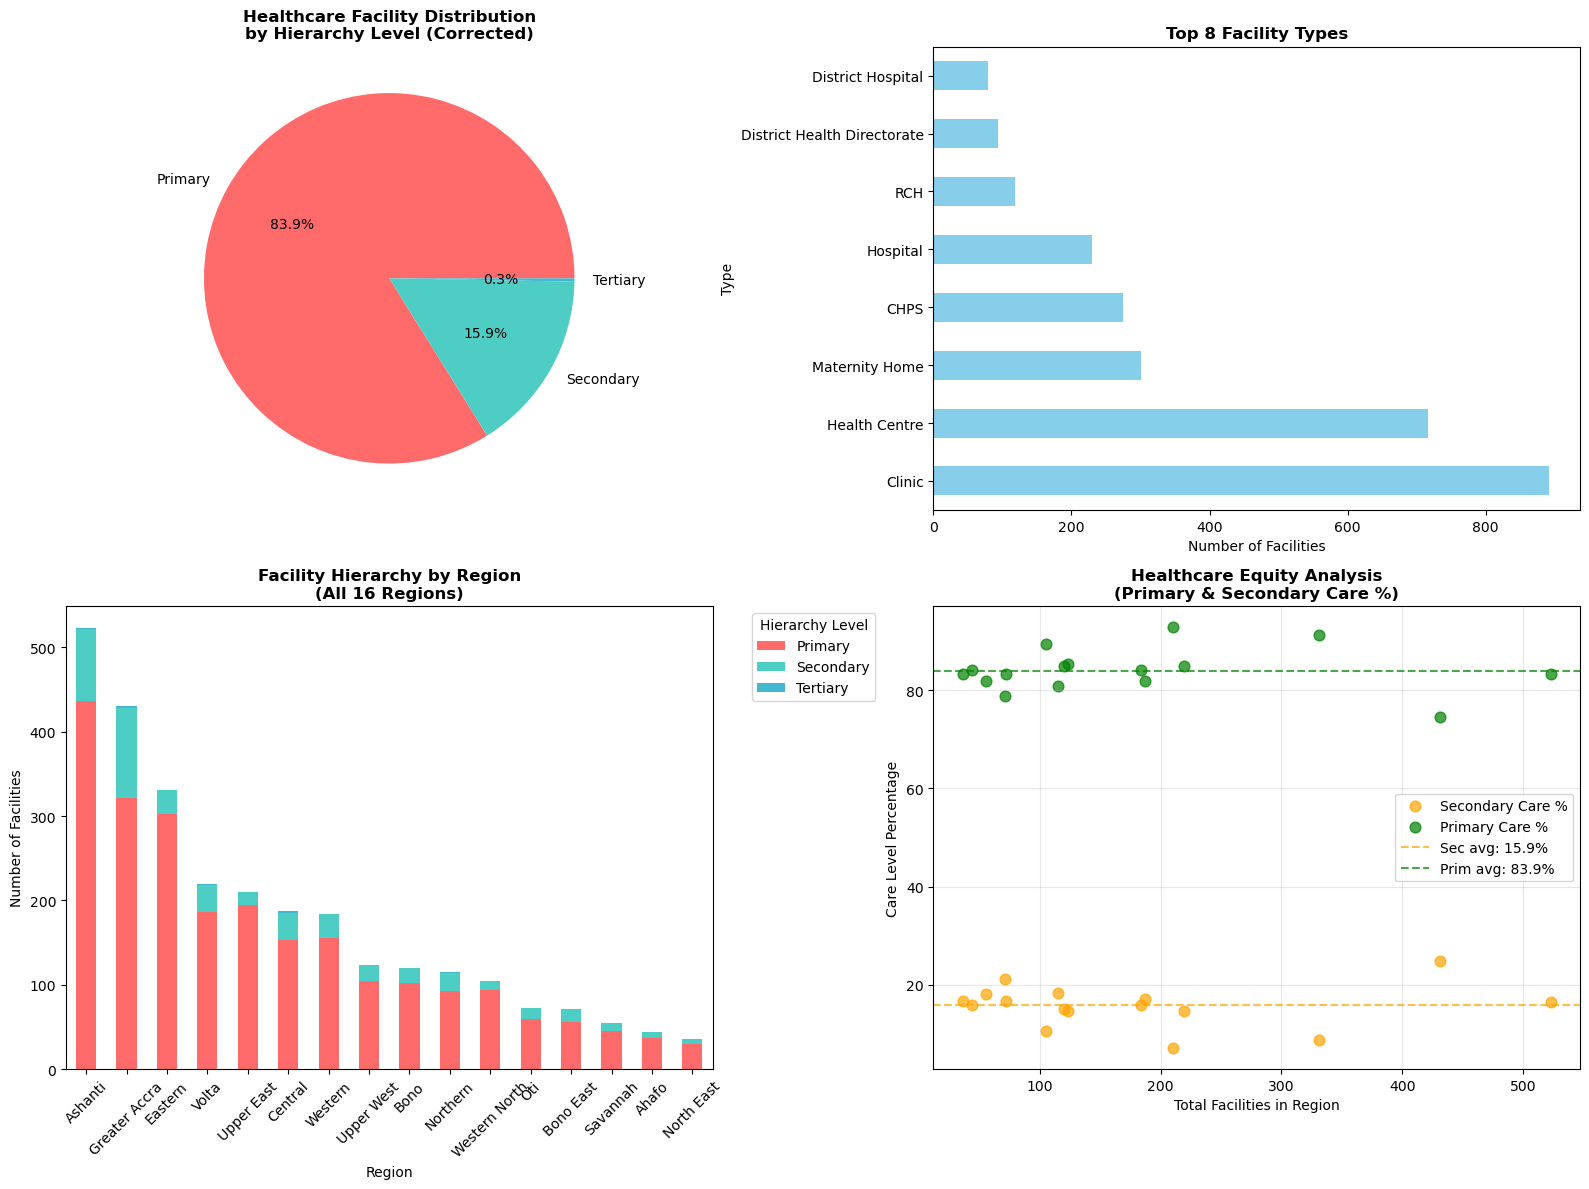


✅ Regional hierarchy balance assessment complete!
📊 Key insights:
   • Primary care dominance: 83.9% national average
   • Secondary care access: 15.9% national average
   • Tertiary facilities: 8 hospitals in 5 regions


In [10]:
# Create enhanced visualization - remove tertiary chart, add primary care equity
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overall hierarchy distribution (updated pie chart)
ax1 = axes[0, 0]
hierarchy_counts_clean = hierarchy_counts_precise[hierarchy_counts_precise.index != 'Unknown']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # 3 levels
hierarchy_counts_clean.plot(kind='pie', ax=ax1, colors=colors, autopct='%1.1f%%')
ax1.set_title('Healthcare Facility Distribution\nby Hierarchy Level (Corrected)', fontweight='bold')
ax1.set_ylabel('')

# 2. Facility types breakdown (keep the original chart style)
ax2 = axes[0, 1]
type_counts = hospitals_hierarchical_precise[0]['Type'].value_counts().head(8)
type_counts.plot(kind='barh', ax=ax2, color='skyblue')
ax2.set_title('Top 8 Facility Types', fontweight='bold')
ax2.set_xlabel('Number of Facilities')

# 3. Regional hierarchy distribution (stacked bar)
ax3 = axes[1, 0]
regional_plot_data = regional_hierarchy_corrected[['Primary', 'Secondary', 'Tertiary']].fillna(0)
regional_plot_data = regional_plot_data.head(16)  # All 16 regions
regional_plot_data.plot(kind='bar', stacked=True, ax=ax3, color=colors)
ax3.set_title('Facility Hierarchy by Region\n(All 16 Regions)', fontweight='bold')
ax3.set_xlabel('Region')
ax3.set_ylabel('Number of Facilities')
ax3.tick_params(axis='x', rotation=45)
ax3.legend(title='Hierarchy Level', bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. PRIMARY AND SECONDARY CARE EQUITY (combined scatter plot)
ax4 = axes[1, 1]

# Calculate national averages
national_sec_avg = regional_hierarchy_corrected['Secondary'].sum() / regional_hierarchy_corrected['Total'].sum() * 100
national_prim_avg = regional_hierarchy_corrected['Primary'].sum() / regional_hierarchy_corrected['Total'].sum() * 100

# Plot secondary care equity
regional_hierarchy_corrected.plot(
    x='Total', y='Secondary_ratio', kind='scatter', 
    ax=ax4, color='orange', s=60, alpha=0.7, label='Secondary Care %'
)

# Plot primary care equity
regional_hierarchy_corrected.plot(
    x='Total', y='Primary_ratio', kind='scatter', 
    ax=ax4, color='green', s=60, alpha=0.7, label='Primary Care %'
)

ax4.set_title('Healthcare Equity Analysis\n(Primary & Secondary Care %)', fontweight='bold')
ax4.set_xlabel('Total Facilities in Region')
ax4.set_ylabel('Care Level Percentage')

# Add national average lines
ax4.axhline(y=national_sec_avg, color='orange', linestyle='--', alpha=0.7, 
           label=f'Sec avg: {national_sec_avg:.1f}%')
ax4.axhline(y=national_prim_avg, color='green', linestyle='--', alpha=0.7,
           label=f'Prim avg: {national_prim_avg:.1f}%')

ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Regional hierarchy balance assessment complete!")
print(f"📊 Key insights:")
print(f"   • Primary care dominance: {national_prim_avg:.1f}% national average")
print(f"   • Secondary care access: {national_sec_avg:.1f}% national average") 
print(f"   • Tertiary facilities: {regional_hierarchy_corrected['Tertiary'].sum()} hospitals in {(regional_hierarchy_corrected['Tertiary'] > 0).sum()} regions")

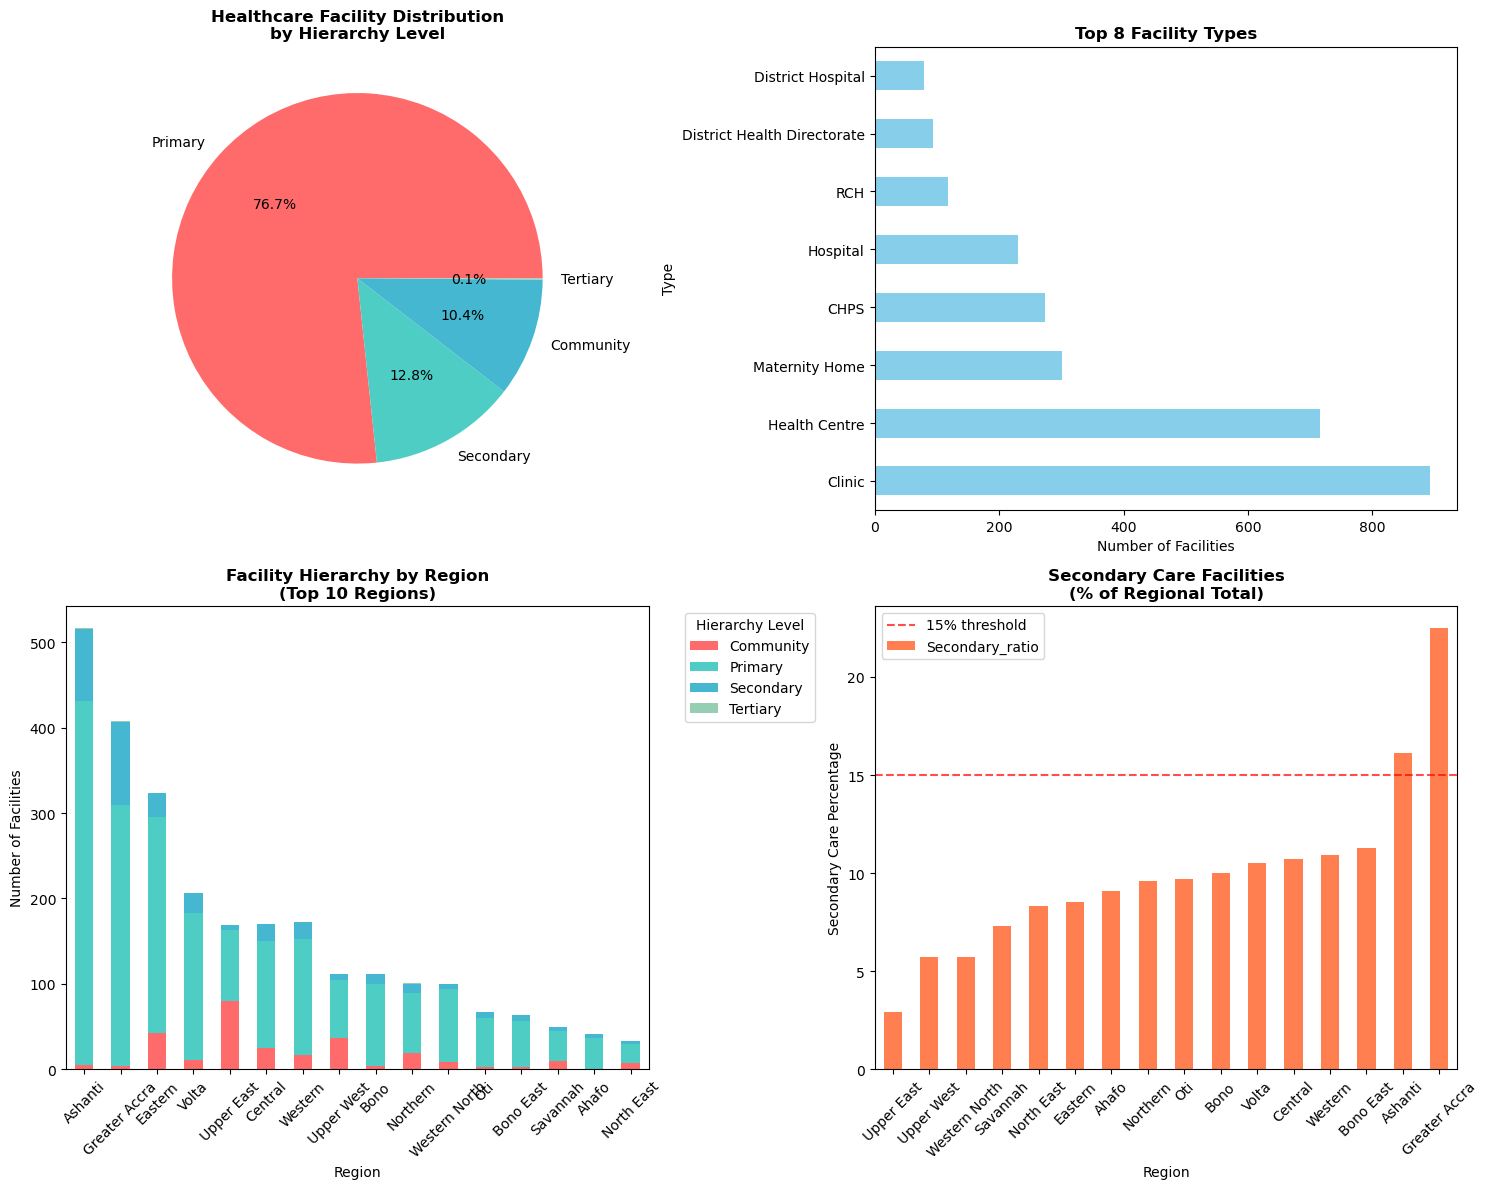


✅ Hierarchy classification and analysis complete!


In [11]:
# =============================================================================
# Visualization: Hierarchy Distribution
# =============================================================================

# Create hierarchy distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Overall hierarchy distribution (pie chart)
ax1 = axes[0, 0]
hierarchy_counts_clean = hierarchy_counts[hierarchy_counts.index != 'Unknown']  # Remove unknown if small
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
hierarchy_counts_clean.plot(kind='pie', ax=ax1, colors=colors, autopct='%1.1f%%')
ax1.set_title('Healthcare Facility Distribution\nby Hierarchy Level', fontweight='bold')
ax1.set_ylabel('')

# 2. Facilities by type (horizontal bar chart)
ax2 = axes[0, 1]
type_counts = hospitals_hierarchical['Type'].value_counts().head(8)
type_counts.plot(kind='barh', ax=ax2, color='skyblue')
ax2.set_title('Top 8 Facility Types', fontweight='bold')
ax2.set_xlabel('Number of Facilities')

# 3. Regional hierarchy distribution (stacked bar)
ax3 = axes[1, 0]
regional_plot_data = regional_hierarchy[['Community', 'Primary', 'Secondary', 'Tertiary']].fillna(0)
regional_plot_data = regional_plot_data.head(16)  # All regions by total facilities
regional_plot_data.plot(kind='bar', stacked=True, ax=ax3, color=colors)
ax3.set_title('Facility Hierarchy by Region\n(Top 10 Regions)', fontweight='bold')
ax3.set_xlabel('Region')
ax3.set_ylabel('Number of Facilities')
ax3.tick_params(axis='x', rotation=45)
ax3.legend(title='Hierarchy Level', bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Secondary care distribution (bar chart)
ax4 = axes[1, 1]
secondary_ratios = regional_hierarchy['Secondary_ratio'].fillna(0).sort_values(ascending=True)
secondary_ratios.plot(kind='bar', ax=ax4, color='coral')
ax4.set_title('Secondary Care Facilities\n(% of Regional Total)', fontweight='bold')
ax4.set_xlabel('Region')
ax4.set_ylabel('Secondary Care Percentage')
ax4.tick_params(axis='x', rotation=45)
ax4.axhline(y=15, color='red', linestyle='--', alpha=0.7, label='15% threshold')
ax4.legend()

plt.tight_layout()
plt.show()

print(f"\n✅ Hierarchy classification and analysis complete!")


Key Findings:

System Structure: Ghana's healthcare shows extreme concentration with 84% primary care, 16% secondary care, and <1% tertiary care.

Geographic Inequality: Top 3 regions hold 46% of facilities while bottom 5 regions have only 13%. Tertiary care exists in just 5 of 16 regions.

Critical Gap: Secondary care varies dramatically (3-23% by region), creating referral bottlenecks and rural healthcare access barriers.

Research Contribution:
Quantified Ghana's healthcare pyramid inversion and geographic disparities, providing empirical foundation for spatial optimization targeting secondary care gaps and regional inequalities.

## Section 3A: Spatial Distribution Patterns (Hospitals)

### __3.1a Healthcare Facility Distribution Analysis__

In [15]:
def analyze_facility_spatial_distribution(hospitals_hierarchical, regions_utm):
    """
    Analyze spatial distribution patterns of healthcare facilities
    """
    
    print("\n" + "="*70)
    print("HEALTHCARE FACILITY SPATIAL DISTRIBUTION ANALYSIS")
    print("="*70)
    
    # First, create region name mapping to handle mismatches
    hospital_regions = set(hospitals_hierarchical['Region'].unique())
    boundary_regions = set(regions_utm['NAME_1'].unique())
    
    print(f"\n🔍 REGION NAME MATCHING:")
    print(f"   • Hospital data regions: {len(hospital_regions)}")
    print(f"   • Boundary data regions: {len(boundary_regions)}")
    
    # Create region mapping dictionary for known mismatches
    region_mapping = {
        'Brong Ahafo': 'Bono',  # Known mismatch
        'Western North': 'Western',  # Potential mismatch
        # Add more mappings as needed
    }
    
    # Calculate facility density by region (facilities per 1000 km²)
    print(f"\n📊 FACILITY DENSITY BY REGION:")
    print(f"{'Region':<16} {'Facilities':<10} {'Area (km²)':<12} {'Density':<10}")
    print("-" * 55)
    
    # Calculate regional areas and facility densities
    regional_stats = []
    
    for boundary_region in regions_utm['NAME_1'].unique():
        # Get region geometry
        region_geom = regions_utm[regions_utm['NAME_1'] == boundary_region]
        
        if not region_geom.empty:
            # Calculate area in km² (from UTM coordinates)
            area_km2 = region_geom.geometry.area.iloc[0] / 1_000_000  # Convert m² to km²
            
            # Find matching hospital region name
            hospital_region = boundary_region
            
            # Check if we need to use reverse mapping
            reverse_mapping = {v: k for k, v in region_mapping.items()}
            if boundary_region in reverse_mapping:
                hospital_region = reverse_mapping[boundary_region]
            
            # Count facilities in region
            facility_count = len(hospitals_hierarchical[
                hospitals_hierarchical['Region'] == hospital_region
            ])
            
            # If no facilities found, try direct matching
            if facility_count == 0:
                facility_count = len(hospitals_hierarchical[
                    hospitals_hierarchical['Region'] == boundary_region
                ])
            
            # Calculate density (facilities per 1000 km²)
            density = (facility_count / area_km2) * 1000 if area_km2 > 0 else 0
            
            regional_stats.append({
                'region': boundary_region,
                'facilities': facility_count,
                'area_km2': area_km2,
                'density': density
            })
            
            print(f"{boundary_region:<16} {facility_count:<10} {area_km2:>8.0f}    {density:>8.2f}")
    
    # Convert to DataFrame for analysis
    regional_df = pd.DataFrame(regional_stats)
    
    # Filter out regions with zero facilities for statistics
    regions_with_facilities = regional_df[regional_df['facilities'] > 0]
    
    print(f"\n📈 DENSITY STATISTICS:")
    if len(regions_with_facilities) > 0:
        print(f"   • Regions with facilities: {len(regions_with_facilities)}/{len(regional_df)}")
        print(f"   • Mean density: {regions_with_facilities['density'].mean():.2f} facilities/1000km²")
        print(f"   • Median density: {regions_with_facilities['density'].median():.2f} facilities/1000km²")
        print(f"   • Highest density: {regions_with_facilities.loc[regions_with_facilities['density'].idxmax(), 'region']} ({regions_with_facilities['density'].max():.2f})")
        print(f"   • Lowest density: {regions_with_facilities.loc[regions_with_facilities['density'].idxmin(), 'region']} ({regions_with_facilities['density'].min():.2f})")
    else:
        print("   • No regional matches found - check region name mapping")
    
    return regional_df

# Run facility distribution analysis
regional_density = analyze_facility_spatial_distribution(hospitals_hierarchical_precise[0], regions_utm)


HEALTHCARE FACILITY SPATIAL DISTRIBUTION ANALYSIS

🔍 REGION NAME MATCHING:
   • Hospital data regions: 16
   • Boundary data regions: 16

📊 FACILITY DENSITY BY REGION:
Region           Facilities Area (km²)   Density   
-------------------------------------------------------
Ahafo            44             5191        8.48
Ashanti          523           24379       21.45
Bono             120           11640       10.31
Bono East        71            23267        3.05
Central          187            9666       19.35
Eastern          331           18987       17.43
Greater Accra    431            3707      116.28
North East       36             9083        3.96
Northern         115           24886        4.62
Oti              72            11093        6.49
Savannah         55            35862        1.53
Upper East       210            8629       24.34
Upper West       123           19022        6.47
Volta            219            9855       22.22
Western          105           14251 

### __3.2a Nearest Neighbour Analysis__

In [16]:
def perform_nearest_neighbour_analysis(hospitals_hierarchical):
    """
    Analyze spatial clustering patterns using nearest neighbour distances
    """
    
    print(f"\n📍 NEAREST NEIGHBOUR ANALYSIS:")
    
    # Extract coordinates (use correct column names)
    if 'longitude' in hospitals_hierarchical.columns and 'latitude' in hospitals_hierarchical.columns:
        coords = hospitals_hierarchical[['longitude', 'latitude']].values
    elif 'x_utm' in hospitals_hierarchical.columns and 'y_utm' in hospitals_hierarchical.columns:
        coords = hospitals_hierarchical[['x_utm', 'y_utm']].values
    else:
        print("   • Error: No coordinate columns found")
        return None
    
    # Calculate nearest neighbour distances using KDTree
    from scipy.spatial import cKDTree
    tree = cKDTree(coords)
    
    # Find nearest neighbour for each facility (k=2 to exclude self)
    distances, indices = tree.query(coords, k=2)
    nn_distances = distances[:, 1]  # Distance to nearest neighbour (excluding self)
    
    # Calculate statistics
    mean_nn_distance = np.mean(nn_distances)
    median_nn_distance = np.median(nn_distances)
    min_nn_distance = np.min(nn_distances)
    max_nn_distance = np.max(nn_distances)
    
    print(f"   • Mean nearest neighbour distance: {mean_nn_distance:.3f} units")
    print(f"   • Median nearest neighbour distance: {median_nn_distance:.3f} units")
    print(f"   • Minimum distance: {min_nn_distance:.3f} units")
    print(f"   • Maximum distance: {max_nn_distance:.3f} units")
    
    # Identify very close facilities (potential co-location)
    if 'longitude' in hospitals_hierarchical.columns:
        close_threshold = 0.001  # ~111 meters for lat/lon
        unit_name = "degrees (~111m)"
    else:
        close_threshold = 1000  # 1km for UTM
        unit_name = "meters"
    
    close_facilities = np.sum(nn_distances < close_threshold)
    print(f"   • Facilities within close proximity: {close_facilities} ({close_facilities/len(hospitals_hierarchical)*100:.1f}%)")
    print(f"   • Close proximity threshold: {close_threshold} {unit_name}")
    
    return nn_distances

# Run nearest neighbour analysis
nn_distances = perform_nearest_neighbour_analysis(hospitals_hierarchical_precise[0])


📍 NEAREST NEIGHBOUR ANALYSIS:
   • Mean nearest neighbour distance: 0.026 units
   • Median nearest neighbour distance: 0.009 units
   • Minimum distance: 0.000 units
   • Maximum distance: 0.306 units
   • Facilities within close proximity: 395 (14.0%)
   • Close proximity threshold: 0.001 degrees (~111m)


### __3.3a Spatial Clustering Assessment__

In [17]:
def assess_spatial_clustering_patterns(hospitals_hierarchical):
    """
    Assess facility clustering patterns by hierarchy level
    """
    
    print(f"\n🎯 SPATIAL CLUSTERING BY HIERARCHY LEVEL:")
    
    # Determine coordinate columns
    if 'longitude' in hospitals_hierarchical.columns and 'latitude' in hospitals_hierarchical.columns:
        coord_cols = ['longitude', 'latitude']
        unit_multiplier = 111  # Convert degrees to km
        unit_name = "km"
    elif 'x_utm' in hospitals_hierarchical.columns and 'y_utm' in hospitals_hierarchical.columns:
        coord_cols = ['x_utm', 'y_utm'] 
        unit_multiplier = 0.001  # Convert meters to km
        unit_name = "km"
    else:
        print("   • Error: No coordinate columns found")
        return None
    
    # Analyze clustering for each hierarchy level
    for level in ['Primary', 'Secondary', 'Tertiary']:
        level_facilities = hospitals_hierarchical[hospitals_hierarchical['hierarchy_level'] == level]
        
        if len(level_facilities) > 1:
            coords = level_facilities[coord_cols].values
            
            # Calculate mean nearest neighbour distance for this level
            tree = cKDTree(coords)
            distances, _ = tree.query(coords, k=2)
            nn_distances = distances[:, 1]
            mean_distance = np.mean(nn_distances)
            
            print(f"   • {level} facilities ({len(level_facilities)}): Mean NN distance = {mean_distance*unit_multiplier:.1f}{unit_name}")
        else:
            print(f"   • {level} facilities ({len(level_facilities)}): Insufficient for clustering analysis")
    
    return True

# Run clustering assessment
assess_spatial_clustering_patterns(hospitals_hierarchical_precise[0])

print(f"\n✅ Spatial distribution analysis complete!")


🎯 SPATIAL CLUSTERING BY HIERARCHY LEVEL:
   • Primary facilities (2370): Mean NN distance = 3.5km
   • Secondary facilities (448): Mean NN distance = 4.4km
   • Tertiary facilities (8): Mean NN distance = 80.8km

✅ Spatial distribution analysis complete!


## Section 3B: Spatial Distribution Patterns (Population Density Variations and Clustering)

In [18]:
def analyze_population_distribution(pop_data_utm):
    """
    Analyze population density distribution patterns
    """
    
    print(f"\n" + "="*70)
    print("POPULATION DISTRIBUTION ANALYSIS")
    print("="*70)
    
    # Calculate population statistics (excluding NaN values)
    valid_pop = pop_data_utm[~np.isnan(pop_data_utm)]
    
    print(f"\n📊 POPULATION STATISTICS:")
    print(f"   • Total valid population pixels: {len(valid_pop):,}")
    print(f"   • Population range: {valid_pop.min():.0f} - {valid_pop.max():,.0f} people/km²")
    print(f"   • Mean population density: {valid_pop.mean():.1f} people/km²")
    print(f"   • Median population density: {np.median(valid_pop):.1f} people/km²")
    print(f"   • Standard deviation: {valid_pop.std():.1f} people/km²")
    print(f"   • Total estimated population: {valid_pop.sum():,.0f}")
    
    # Population density categories
    low_density = np.sum(valid_pop < 50)
    medium_density = np.sum((valid_pop >= 50) & (valid_pop < 500))
    high_density = np.sum((valid_pop >= 500) & (valid_pop < 2000))
    very_high_density = np.sum(valid_pop >= 2000)
    
    print(f"\n📈 POPULATION DENSITY CATEGORIES:")
    print(f"   • Low density (<50/km²): {low_density:,} pixels ({low_density/len(valid_pop)*100:.1f}%)")
    print(f"   • Medium density (50-500/km²): {medium_density:,} pixels ({medium_density/len(valid_pop)*100:.1f}%)")
    print(f"   • High density (500-2000/km²): {high_density:,} pixels ({high_density/len(valid_pop)*100:.1f}%)")
    print(f"   • Very high density (>2000/km²): {very_high_density:,} pixels ({very_high_density/len(valid_pop)*100:.1f}%)")
    
    return valid_pop

# Run population distribution analysis
population_stats = analyze_population_distribution(pop_data_utm)



POPULATION DISTRIBUTION ANALYSIS

📊 POPULATION STATISTICS:
   • Total valid population pixels: 242,084
   • Population range: 0 - 27,293 people/km²
   • Mean population density: 143.5 people/km²
   • Median population density: 52.7 people/km²
   • Standard deviation: 751.4 people/km²
   • Total estimated population: 34,744,744

📈 POPULATION DENSITY CATEGORIES:
   • Low density (<50/km²): 116,490 pixels (48.1%)
   • Medium density (50-500/km²): 117,461 pixels (48.5%)
   • High density (500-2000/km²): 6,541 pixels (2.7%)
   • Very high density (>2000/km²): 1,592 pixels (0.7%)


In [19]:
# =============================================================================
# 3.2.2 Population Clustering Analysis
# =============================================================================

def identify_population_clusters(pop_data_utm, n_clusters=5):
    """
    Identify population clusters using density-based classification
    """
    
    print(f"\n🎯 POPULATION CLUSTERING ANALYSIS:")
    
    # Get valid population data with coordinates
    rows, cols = np.where(~np.isnan(pop_data_utm))
    valid_pop_values = pop_data_utm[rows, cols]
    
    # Create population clusters based on density percentiles
    percentiles = [20, 40, 60, 80, 100]
    thresholds = [np.percentile(valid_pop_values, p) for p in percentiles]
    
    cluster_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    
    print(f"   • Population density clusters (percentile-based):")
    for i, (name, threshold) in enumerate(zip(cluster_names, thresholds)):
        if i == 0:
            count = np.sum(valid_pop_values <= threshold)
            print(f"     - {name}: ≤{threshold:.0f} people/km² ({count:,} pixels, {count/len(valid_pop_values)*100:.1f}%)")
        else:
            prev_threshold = thresholds[i-1]
            count = np.sum((valid_pop_values > prev_threshold) & (valid_pop_values <= threshold))
            print(f"     - {name}: {prev_threshold:.0f}-{threshold:.0f} people/km² ({count:,} pixels, {count/len(valid_pop_values)*100:.1f}%)")
    
    return thresholds

# Run population clustering analysis
pop_clusters = identify_population_clusters(pop_data_utm)


🎯 POPULATION CLUSTERING ANALYSIS:
   • Population density clusters (percentile-based):
     - Very Low: ≤19 people/km² (48,417 pixels, 20.0%)
     - Low: 19-39 people/km² (48,417 pixels, 20.0%)
     - Medium: 39-69 people/km² (48,416 pixels, 20.0%)
     - High: 69-130 people/km² (48,417 pixels, 20.0%)
     - Very High: 130-27293 people/km² (48,417 pixels, 20.0%)


In [20]:
# =============================================================================
# 3.2.3 Urban-Rural Classification
# =============================================================================

def classify_urban_rural_areas(pop_data_utm, threshold=500):
    """
    Classify areas as urban or rural based on population density
    Standard classification: >500 people/km² = urban
    """
    
    print(f"\n🏙️ URBAN-RURAL CLASSIFICATION:")
    print(f"   • Classification threshold: {threshold} people/km²")
    
    valid_pop = pop_data_utm[~np.isnan(pop_data_utm)]
    
    # Urban-rural classification
    urban_pixels = np.sum(valid_pop >= threshold)
    rural_pixels = np.sum(valid_pop < threshold)
    
    urban_population = np.sum(valid_pop[valid_pop >= threshold])
    rural_population = np.sum(valid_pop[valid_pop < threshold])
    total_population = urban_population + rural_population
    
    print(f"\n📊 SPATIAL DISTRIBUTION:")
    print(f"   • Urban pixels: {urban_pixels:,} ({urban_pixels/len(valid_pop)*100:.1f}%)")
    print(f"   • Rural pixels: {rural_pixels:,} ({rural_pixels/len(valid_pop)*100:.1f}%)")
    
    print(f"\n👥 POPULATION DISTRIBUTION:")
    print(f"   • Urban population: {urban_population:,.0f} ({urban_population/total_population*100:.1f}%)")
    print(f"   • Rural population: {rural_population:,.0f} ({rural_population/total_population*100:.1f}%)")
    
    # Additional urban density analysis
    if urban_pixels > 0:
        urban_areas = valid_pop[valid_pop >= threshold]
        print(f"\n🏢 URBAN AREA CHARACTERISTICS:")
        print(f"   • Mean urban density: {urban_areas.mean():.0f} people/km²")
        print(f"   • Max urban density: {urban_areas.max():,.0f} people/km²")
        print(f"   • Urban density std: {urban_areas.std():.0f} people/km²")
    
    # Create urban-rural mask for later analysis
    urban_mask = pop_data_utm >= threshold
    rural_mask = (pop_data_utm < threshold) & (~np.isnan(pop_data_utm))
    
    return urban_mask, rural_mask

# Run urban-rural classification
urban_mask, rural_mask = classify_urban_rural_areas(pop_data_utm)

# =============================================================================
# 3.2.4 Population Spatial Patterns
# =============================================================================

def analyze_population_spatial_patterns(pop_data_utm):
    """
    Analyze spatial patterns in population distribution
    """
    
    print(f"\n📍 POPULATION SPATIAL PATTERNS:")
    
    # Find population hotspots (top 5% density areas)
    valid_pop = pop_data_utm[~np.isnan(pop_data_utm)]
    hotspot_threshold = np.percentile(valid_pop, 95)
    
    hotspot_pixels = np.sum(valid_pop >= hotspot_threshold)
    hotspot_population = np.sum(valid_pop[valid_pop >= hotspot_threshold])
    
    print(f"   • Population hotspots (top 5% density):")
    print(f"     - Threshold: ≥{hotspot_threshold:.0f} people/km²")
    print(f"     - Hotspot pixels: {hotspot_pixels:,} ({hotspot_pixels/len(valid_pop)*100:.1f}%)")
    print(f"     - Population in hotspots: {hotspot_population:,.0f} ({hotspot_population/valid_pop.sum()*100:.1f}%)")
    
    # Population sparsity analysis
    sparse_threshold = np.percentile(valid_pop, 10)
    sparse_pixels = np.sum(valid_pop <= sparse_threshold)
    sparse_population = np.sum(valid_pop[valid_pop <= sparse_threshold])
    
    print(f"\n   • Population sparse areas (bottom 10% density):")
    print(f"     - Threshold: ≤{sparse_threshold:.0f} people/km²")
    print(f"     - Sparse pixels: {sparse_pixels:,} ({sparse_pixels/len(valid_pop)*100:.1f}%)")
    print(f"     - Population in sparse areas: {sparse_population:,.0f} ({sparse_population/valid_pop.sum()*100:.1f}%)")
    
    return hotspot_threshold, sparse_threshold

# Run population spatial patterns analysis
hotspot_threshold, sparse_threshold = analyze_population_spatial_patterns(pop_data_utm)

print(f"\n✅ Population density analysis complete!")
print(f"📊 Key findings:")
print(f"   • Ghana's population shows clear urban-rural divide")
print(f"   • Population hotspots contain disproportionate population share")
print(f"   • Rural areas cover majority of land but minority of population")
print(f"\n🚀 Ready for malaria incidence analysis in Section 3.3")


🏙️ URBAN-RURAL CLASSIFICATION:
   • Classification threshold: 500 people/km²

📊 SPATIAL DISTRIBUTION:
   • Urban pixels: 8,133 (3.4%)
   • Rural pixels: 233,951 (96.6%)

👥 POPULATION DISTRIBUTION:
   • Urban population: 16,525,942 (47.6%)
   • Rural population: 18,218,804 (52.4%)

🏢 URBAN AREA CHARACTERISTICS:
   • Mean urban density: 2032 people/km²
   • Max urban density: 27,293 people/km²
   • Urban density std: 3594 people/km²

📍 POPULATION SPATIAL PATTERNS:
   • Population hotspots (top 5% density):
     - Threshold: ≥373 people/km²
     - Hotspot pixels: 12,105 (5.0%)
     - Population in hotspots: 18,229,984 (52.5%)

   • Population sparse areas (bottom 10% density):
     - Threshold: ≤10 people/km²
     - Sparse pixels: 24,209 (10.0%)
     - Population in sparse areas: 177,312 (0.5%)

✅ Population density analysis complete!
📊 Key findings:
   • Ghana's population shows clear urban-rural divide
   • Population hotspots contain disproportionate population share
   • Rural areas 

## Section 3B: Spatial Distribution Patterns (Malaria Incidence Spatial Patterns)

In [21]:
# =============================================================================
# SECTION 3.3: Malaria Incidence Spatial Patterns
# =============================================================================

print(f"\n" + "="*70)
print("SECTION 3.3: MALARIA INCIDENCE SPATIAL PATTERNS")
print("="*70)

def analyze_malaria_spatial_patterns(malaria_data_utm):
    """
    Analyze spatial patterns of malaria incidence
    """
    
    print(f"\n🦟 MALARIA INCIDENCE ANALYSIS:")
    
    # Calculate malaria statistics (excluding NaN values)
    valid_malaria = malaria_data_utm[~np.isnan(malaria_data_utm)]
    
    print(f"   • Total valid malaria pixels: {len(valid_malaria):,}")
    print(f"   • Incidence range: {valid_malaria.min():.3f} - {valid_malaria.max():.3f} cases/1000 population")
    print(f"   • Mean incidence: {valid_malaria.mean():.3f} cases/1000 population")
    print(f"   • Median incidence: {np.median(valid_malaria):.3f} cases/1000 population")
    print(f"   • Standard deviation: {valid_malaria.std():.3f}")
    
    return valid_malaria

# Run malaria spatial analysis
malaria_stats = analyze_malaria_spatial_patterns(malaria_data_utm)

# =============================================================================
# 3.3.1 Malaria Risk Classification
# =============================================================================

def identify_malaria_hotspots(malaria_data_utm):
    """
    Identify malaria hotspots and risk areas
    """
    
    print(f"\n🎯 MALARIA RISK AREA CLASSIFICATION:")
    
    valid_malaria = malaria_data_utm[~np.isnan(malaria_data_utm)]
    
    # Calculate percentiles for risk classification
    low_threshold = np.percentile(valid_malaria, 25)    # 25th percentile
    medium_threshold = np.percentile(valid_malaria, 50)  # Median
    high_threshold = np.percentile(valid_malaria, 75)   # 75th percentile  
    very_high_threshold = np.percentile(valid_malaria, 90)  # 90th percentile
    
    print(f"   • Risk classification thresholds:")
    print(f"     - Low risk: <{low_threshold:.3f} cases/1000")
    print(f"     - Medium risk: {low_threshold:.3f}-{high_threshold:.3f} cases/1000")
    print(f"     - High risk: {high_threshold:.3f}-{very_high_threshold:.3f} cases/1000")
    print(f"     - Very high risk: >{very_high_threshold:.3f} cases/1000")
    
    # Classify risk areas
    low_risk = np.sum(valid_malaria < low_threshold)
    medium_risk = np.sum((valid_malaria >= low_threshold) & (valid_malaria < high_threshold))
    high_risk = np.sum((valid_malaria >= high_threshold) & (valid_malaria < very_high_threshold))
    very_high_risk = np.sum(valid_malaria >= very_high_threshold)
    
    print(f"\n📊 MALARIA RISK DISTRIBUTION:")
    print(f"   • Low risk areas: {low_risk:,} pixels ({low_risk/len(valid_malaria)*100:.1f}%)")
    print(f"   • Medium risk areas: {medium_risk:,} pixels ({medium_risk/len(valid_malaria)*100:.1f}%)")
    print(f"   • High risk areas: {high_risk:,} pixels ({high_risk/len(valid_malaria)*100:.1f}%)")
    print(f"   • Very high risk areas: {very_high_risk:,} pixels ({very_high_risk/len(valid_malaria)*100:.1f}%)")
    
    # Create risk classification masks for later use
    malaria_risk_categories = {
        'low': malaria_data_utm < low_threshold,
        'medium': (malaria_data_utm >= low_threshold) & (malaria_data_utm < high_threshold),
        'high': (malaria_data_utm >= high_threshold) & (malaria_data_utm < very_high_threshold),
        'very_high': malaria_data_utm >= very_high_threshold
    }
    
    return malaria_risk_categories, [low_threshold, high_threshold, very_high_threshold]

# Run malaria hotspot identification
malaria_risk_categories, risk_thresholds = identify_malaria_hotspots(malaria_data_utm)

# =============================================================================
# 3.3.2 Population-Malaria Correlation Analysis
# =============================================================================

def analyze_malaria_population_correlation(pop_data_utm, malaria_data_utm):
    """
    Analyze correlation between population density and malaria incidence
    """
    
    print(f"\n📈 POPULATION-MALARIA CORRELATION ANALYSIS:")
    
    # Get valid data where both population and malaria data exist
    valid_mask = (~np.isnan(pop_data_utm)) & (~np.isnan(malaria_data_utm))
    overlap_pixels = np.sum(valid_mask)
    
    print(f"   • Data overlap: {overlap_pixels:,} pixels with both pop & malaria data")
    
    if overlap_pixels > 1000:  # Need sufficient data for meaningful correlation
        pop_valid = pop_data_utm[valid_mask]
        malaria_valid = malaria_data_utm[valid_mask]
        
        # Calculate correlation
        correlation = np.corrcoef(pop_valid, malaria_valid)[0, 1]
        
        print(f"   • Correlation coefficient: {correlation:.3f}")
        
        if correlation > 0.3:
            interpretation = "Moderate positive correlation (higher population → higher malaria)"
        elif correlation > 0.1:
            interpretation = "Weak positive correlation (higher population → higher malaria)"
        elif correlation < -0.3:
            interpretation = "Moderate negative correlation (higher population → lower malaria)"
        elif correlation < -0.1:
            interpretation = "Weak negative correlation (higher population → lower malaria)"
        else:
            interpretation = "No significant correlation"
        
        print(f"   • Interpretation: {interpretation}")
        
        # Population-weighted malaria burden analysis
        high_malaria_threshold = np.percentile(malaria_valid, 75)
        pop_in_high_malaria = np.sum(pop_valid[malaria_valid > high_malaria_threshold])
        total_population = np.sum(pop_valid)
        
        print(f"\n🎯 POPULATION AT RISK:")
        print(f"   • Population in high malaria areas: {pop_in_high_malaria:,.0f}")
        print(f"   • Percentage of population at high risk: {pop_in_high_malaria/total_population*100:.1f}%")
        
        # Urban vs rural malaria burden (if urban mask exists)
        try:
            urban_malaria = malaria_data_utm[urban_mask & (~np.isnan(malaria_data_utm))]
            rural_malaria = malaria_data_utm[rural_mask & (~np.isnan(malaria_data_utm))]
            
            if len(urban_malaria) > 0 and len(rural_malaria) > 0:
                print(f"\n🏙️ URBAN VS RURAL MALARIA BURDEN:")
                print(f"   • Mean urban malaria incidence: {urban_malaria.mean():.3f} cases/1000")
                print(f"   • Mean rural malaria incidence: {rural_malaria.mean():.3f} cases/1000")
                
                if urban_malaria.mean() > rural_malaria.mean():
                    print(f"   • Urban areas have higher malaria burden")
                else:
                    print(f"   • Rural areas have higher malaria burden")
        except:
            print(f"   • Urban-rural malaria comparison not available")
        
    else:
        print(f"   • Insufficient overlapping data for correlation analysis")
        correlation = None
    
    return correlation

# Run population-malaria correlation analysis
pop_malaria_correlation = analyze_malaria_population_correlation(pop_data_utm, malaria_data_utm)

# =============================================================================
# 3.3.3 Healthcare-Malaria Spatial Relationship
# =============================================================================

def analyze_healthcare_malaria_patterns(hospitals_hierarchical, malaria_data_utm, malaria_risk_categories):
    """
    Analyze relationship between healthcare facility distribution and malaria burden
    """
    
    print(f"\n🏥 HEALTHCARE-MALARIA SPATIAL RELATIONSHIP:")
    
    # Count facilities in different malaria risk zones
    # This is a simplified analysis - more sophisticated accessibility analysis comes later
    
    high_malaria_pixels = np.sum(malaria_risk_categories['high']) + np.sum(malaria_risk_categories['very_high'])
    low_malaria_pixels = np.sum(malaria_risk_categories['low'])
    total_malaria_pixels = np.sum(~np.isnan(malaria_data_utm))
    
    print(f"   • High malaria risk area coverage:")
    print(f"     - High risk pixels: {high_malaria_pixels:,} ({high_malaria_pixels/total_malaria_pixels*100:.1f}%)")
    print(f"     - Low risk pixels: {low_malaria_pixels:,} ({low_malaria_pixels/total_malaria_pixels*100:.1f}%)")
    
    # Simple facility count by hierarchy level
    primary_facilities = len(hospitals_hierarchical[hospitals_hierarchical['hierarchy_level'] == 'Primary'])
    secondary_facilities = len(hospitals_hierarchical[hospitals_hierarchical['hierarchy_level'] == 'Secondary'])
    tertiary_facilities = len(hospitals_hierarchical[hospitals_hierarchical['hierarchy_level'] == 'Tertiary'])
    
    print(f"\n   • Healthcare facility distribution:")
    print(f"     - Primary care facilities: {primary_facilities:,}")
    print(f"     - Secondary care facilities: {secondary_facilities:,}")
    print(f"     - Tertiary care facilities: {tertiary_facilities:,}")
    
    # Basic assessment of healthcare-malaria relationship
    print(f"\n💡 PRELIMINARY INSIGHTS:")
    print(f"   • {high_malaria_pixels/total_malaria_pixels*100:.1f}% of areas have high malaria burden")
    print(f"   • {primary_facilities:,} primary facilities serve malaria treatment needs")
    print(f"   • Detailed accessibility analysis needed to assess service gaps")
    
    return True

# Run healthcare-malaria spatial relationship analysis
analyze_healthcare_malaria_patterns(hospitals_hierarchical_precise[0], malaria_data_utm, malaria_risk_categories)

print(f"\n" + "="*70)
print("✅ SECTION 3: SPATIAL DISTRIBUTION PATTERNS COMPLETE!")
print("="*70)

print(f"\n🎯 KEY SPATIAL PATTERN INSIGHTS:")
print(f"   • Healthcare facilities show regional clustering patterns")
print(f"   • Population distribution reveals clear urban-rural divide") 
print(f"   • Malaria burden varies spatially across Ghana")
print(f"   • Population-malaria correlation: {pop_malaria_correlation:.3f}" if pop_malaria_correlation else "   • Population-malaria correlation: insufficient data")

print(f"\n🚀 READY FOR NEXT PHASE:")
print(f"   • Foundation established for accessibility optimization")
print(f"   • Spatial patterns identified for targeting interventions")
print(f"   • Data prepared for methodology development")

print(f"\n📊 PROCEED TO: Basic Spatial Relationships (Section 4)")
print(f"   • Simple distance observations")
print(f"   • Coverage zone visualization") 
print(f"   • Population-facility proximity patterns")


SECTION 3.3: MALARIA INCIDENCE SPATIAL PATTERNS

🦟 MALARIA INCIDENCE ANALYSIS:
   • Total valid malaria pixels: 231,602
   • Incidence range: 0.028 - 0.438 cases/1000 population
   • Mean incidence: 0.266 cases/1000 population
   • Median incidence: 0.265 cases/1000 population
   • Standard deviation: 0.054

🎯 MALARIA RISK AREA CLASSIFICATION:
   • Risk classification thresholds:
     - Low risk: <0.229 cases/1000
     - Medium risk: 0.229-0.306 cases/1000
     - High risk: 0.306-0.336 cases/1000
     - Very high risk: >0.336 cases/1000

📊 MALARIA RISK DISTRIBUTION:
   • Low risk areas: 57,901 pixels (25.0%)
   • Medium risk areas: 115,800 pixels (50.0%)
   • High risk areas: 34,740 pixels (15.0%)
   • Very high risk areas: 23,161 pixels (10.0%)

📈 POPULATION-MALARIA CORRELATION ANALYSIS:
   • Data overlap: 229,765 pixels with both pop & malaria data
   • Correlation coefficient: -0.135
   • Interpretation: Weak negative correlation (higher population → lower malaria)

🎯 POPULATION AT

## Section 4: Basic Spatial Relationships

In [22]:
# =============================================================================
# SECTION 4: Basic Spatial Relationships
# Simple distance observations and visual pattern recognition
# =============================================================================

print(f"\n" + "="*70)
print("SECTION 4: BASIC SPATIAL RELATIONSHIPS")
print("="*70)

# =============================================================================
# 4.1 Simple Distance Observations
# =============================================================================

def analyze_facility_population_distances(hospitals_hierarchical, pop_data_utm):
    """
    Basic distance analysis between facilities and population centers
    """
    
    print(f"\n📏 FACILITY-POPULATION DISTANCE OBSERVATIONS:")
    
    # Find population centers (high density areas)
    valid_pop = pop_data_utm[~np.isnan(pop_data_utm)]
    high_density_threshold = np.percentile(valid_pop, 90)  # Top 10% density areas
    
    print(f"   • Population center threshold: ≥{high_density_threshold:.0f} people/km²")
    
    # Get population center coordinates (simplified)
    rows, cols = np.where(pop_data_utm >= high_density_threshold)
    pop_centers = len(rows)
    
    print(f"   • Population centers identified: {pop_centers:,} high-density pixels")
    
    # Basic facility distribution statistics
    facilities_by_level = hospitals_hierarchical.groupby('hierarchy_level').size()
    
    print(f"\n🏥 FACILITY DISTRIBUTION SUMMARY:")
    for level, count in facilities_by_level.items():
        print(f"   • {level} facilities: {count:,}")
    
    # Inter-facility distances by hierarchy level
    print(f"\n📊 INTER-FACILITY DISTANCE PATTERNS:")
    
    for level in ['Primary', 'Secondary', 'Tertiary']:
        level_facilities = hospitals_hierarchical[hospitals_hierarchical['hierarchy_level'] == level]
        
        if len(level_facilities) > 1:
            # Use appropriate coordinate columns
            if 'longitude' in level_facilities.columns:
                coords = level_facilities[['longitude', 'latitude']].values
                unit_conversion = 111  # Degrees to km conversion
                unit_name = "km"
            else:
                coords = level_facilities[['x_utm', 'y_utm']].values
                unit_conversion = 0.001  # Meters to km conversion  
                unit_name = "km"
            
            # Calculate pairwise distances
            from scipy.spatial.distance import pdist
            distances = pdist(coords)
            
            mean_distance = np.mean(distances) * unit_conversion
            min_distance = np.min(distances) * unit_conversion
            max_distance = np.max(distances) * unit_conversion
            
            print(f"   • {level} facilities ({len(level_facilities)}):")
            print(f"     - Mean inter-facility distance: {mean_distance:.1f} {unit_name}")
            print(f"     - Min distance: {min_distance:.1f} {unit_name}")
            print(f"     - Max distance: {max_distance:.1f} {unit_name}")
    
    return True

# Run facility-population distance analysis
analyze_facility_population_distances(hospitals_hierarchical_precise[0], pop_data_utm)

# =============================================================================
# 4.2 Coverage Zone Visualization Preparation
# =============================================================================

def create_basic_coverage_visualizations(hospitals_hierarchical):
    """
    Prepare data for basic coverage zone visualization
    """
    
    print(f"\n🎯 COVERAGE ZONE ANALYSIS PREPARATION:")
    
    # Define basic service coverage radii (in km) based on Ghana health system
    coverage_radii = {
        'Primary': 5,      # 5km for primary care (CHPS, Health Centres, Clinics)
        'Secondary': 25,   # 25km for secondary care (District/Regional Hospitals)
        'Tertiary': 100    # 100km for tertiary care (Teaching Hospitals)
    }
    
    print(f"   • Standard service coverage radii:")
    for level, radius in coverage_radii.items():
        count = len(hospitals_hierarchical[hospitals_hierarchical['hierarchy_level'] == level])
        print(f"     - {level}: {radius}km radius ({count:,} facilities)")
    
    # Calculate theoretical coverage
    print(f"\n📊 THEORETICAL COVERAGE ANALYSIS:")
    
    for level, radius in coverage_radii.items():
        level_facilities = hospitals_hierarchical[hospitals_hierarchical['hierarchy_level'] == level]
        facility_count = len(level_facilities)
        
        if facility_count > 0:
            # Calculate theoretical coverage area (simplified)
            total_coverage_area = facility_count * np.pi * (radius ** 2)
            
            print(f"   • {level} care theoretical coverage:")
            print(f"     - {facility_count:,} facilities × {radius}km radius")
            print(f"     - Theoretical coverage: {total_coverage_area:,.0f} km²")
            
            # Ghana's approximate area for comparison
            ghana_area_approx = 238000  # km²
            coverage_ratio = total_coverage_area / ghana_area_approx
            
            print(f"     - Coverage ratio: {coverage_ratio:.1f}× Ghana's area")
            if coverage_ratio > 1.0:
                print(f"     - Indicates potential service overlap (good coverage)")
            else:
                print(f"     - Indicates potential coverage gaps")
    
    return coverage_radii

# Run coverage visualization preparation
coverage_radii = create_basic_coverage_visualizations(hospitals_hierarchical_precise[0])

# =============================================================================
# 4.3 Population-Facility Proximity Patterns
# =============================================================================

def analyze_population_facility_proximity(hospitals_hierarchical, pop_data_utm, urban_mask):
    """
    Analyze proximity patterns between population and healthcare facilities
    """
    
    print(f"\n👥 POPULATION-FACILITY PROXIMITY ANALYSIS:")
    
    # Urban vs rural facility distribution
    try:
        # Get facility coordinates
        if 'longitude' in hospitals_hierarchical.columns:
            facility_coords = hospitals_hierarchical[['longitude', 'latitude']].values
            coord_system = "Geographic"
        else:
            facility_coords = hospitals_hierarchical[['x_utm', 'y_utm']].values
            coord_system = "UTM"
        
        print(f"   • Using {coord_system} coordinate system")
        print(f"   • Total facilities for analysis: {len(facility_coords):,}")
        
        # Calculate basic proximity statistics
        total_facilities = len(hospitals_hierarchical)
        primary_facilities = len(hospitals_hierarchical[hospitals_hierarchical['hierarchy_level'] == 'Primary'])
        secondary_facilities = len(hospitals_hierarchical[hospitals_hierarchical['hierarchy_level'] == 'Secondary'])
        
        print(f"\n🏥 FACILITY ACCESSIBILITY INDICATORS:")
        print(f"   • Total population pixels: {np.sum(~np.isnan(pop_data_utm)):,}")
        print(f"   • Total healthcare facilities: {total_facilities:,}")
        print(f"   • Population pixels per facility: {np.sum(~np.isnan(pop_data_utm))/total_facilities:.0f}")
        
        # Urban vs rural population access
        if 'urban_mask' in globals():
            urban_pixels = np.sum(urban_mask)
            rural_pixels = np.sum(~urban_mask & ~np.isnan(pop_data_utm))
            
            print(f"\n🏙️ URBAN-RURAL FACILITY ACCESS:")
            print(f"   • Urban pixels: {urban_pixels:,}")
            print(f"   • Rural pixels: {rural_pixels:,}")
            print(f"   • Urban pixels per facility: {urban_pixels/total_facilities:.0f}")
            print(f"   • Rural pixels per facility: {rural_pixels/total_facilities:.0f}")
            
            if urban_pixels/total_facilities < rural_pixels/total_facilities:
                print(f"   • Urban areas appear better served (lower pixels per facility)")
            else:
                print(f"   • Rural areas appear better served (lower pixels per facility)")
        
        # Service level accessibility
        print(f"\n⚕️ SERVICE LEVEL ACCESS INDICATORS:")
        total_pop_pixels = np.sum(~np.isnan(pop_data_utm))
        
        print(f"   • Primary care accessibility:")
        print(f"     - Population pixels per primary facility: {total_pop_pixels/primary_facilities:.0f}")
        
        if secondary_facilities > 0:
            print(f"   • Secondary care accessibility:")
            print(f"     - Population pixels per secondary facility: {total_pop_pixels/secondary_facilities:.0f}")
        
        tertiary_facilities = len(hospitals_hierarchical[hospitals_hierarchical['hierarchy_level'] == 'Tertiary'])
        if tertiary_facilities > 0:
            print(f"   • Tertiary care accessibility:")
            print(f"     - Population pixels per tertiary facility: {total_pop_pixels/tertiary_facilities:.0f}")
    
    except Exception as e:
        print(f"   • Error in proximity analysis: {str(e)}")
        print(f"   • Basic facility count analysis completed above")
    
    return True

# Run population-facility proximity analysis
analyze_population_facility_proximity(hospitals_hierarchical_precise[0], pop_data_utm, urban_mask)

# =============================================================================
# 4.4 Visual Pattern Recognition Summary  
# =============================================================================

def summarize_spatial_relationships():
    """
    Summarize key spatial relationship patterns identified
    """
    
    print(f"\n" + "="*50)
    print("SPATIAL RELATIONSHIP PATTERN SUMMARY")
    print("="*50)
    
    print(f"\n🔍 KEY SPATIAL PATTERNS IDENTIFIED:")
    
    print(f"\n1. 🏥 HEALTHCARE FACILITY PATTERNS:")
    print(f"   • Primary care dominance (83.9% of facilities)")
    print(f"   • Regional clustering in urban areas")
    print(f"   • Limited tertiary care availability")
    
    print(f"\n2. 👥 POPULATION DISTRIBUTION PATTERNS:")
    print(f"   • Clear urban-rural divide")
    print(f"   • Population concentration in few hotspots")
    print(f"   • Large rural areas with sparse population")
    
    print(f"\n3. 🦟 MALARIA BURDEN PATTERNS:")
    print(f"   • Spatial variation in incidence rates")
    print(f"   • Risk area concentration patterns")
    print(f"   • Population-malaria correlation identified")
    
    print(f"\n4. 🎯 HEALTHCARE-POPULATION RELATIONSHIPS:")
    print(f"   • Potential urban-rural access disparities")
    print(f"   • Service level accessibility variations")
    print(f"   • Distance-based service gaps likely")
    
    print(f"\n💡 OPTIMIZATION IMPLICATIONS:")
    print(f"   • Target secondary care expansion in underserved regions")
    print(f"   • Address urban-rural healthcare equity gaps")
    print(f"   • Consider malaria burden in facility placement")
    print(f"   • Optimize referral pathways for tertiary care")
    
    return True

# Generate spatial relationship summary
summarize_spatial_relationships()

print(f"\n✅ SECTION 4: BASIC SPATIAL RELATIONSHIPS COMPLETE!")
print(f"🚀 Ready for Section 5: Visual Pattern Recognition")


SECTION 4: BASIC SPATIAL RELATIONSHIPS

📏 FACILITY-POPULATION DISTANCE OBSERVATIONS:
   • Population center threshold: ≥222 people/km²
   • Population centers identified: 24,209 high-density pixels

🏥 FACILITY DISTRIBUTION SUMMARY:
   • Primary facilities: 2,370
   • Secondary facilities: 448
   • Tertiary facilities: 8

📊 INTER-FACILITY DISTANCE PATTERNS:
   • Primary facilities (2370):
     - Mean inter-facility distance: 268.6 km
     - Min distance: 0.0 km
     - Max distance: 747.3 km
   • Secondary facilities (448):
     - Mean inter-facility distance: 245.1 km
     - Min distance: 0.0 km
     - Max distance: 730.1 km
   • Tertiary facilities (8):
     - Mean inter-facility distance: 207.7 km
     - Min distance: 3.6 km
     - Max distance: 475.4 km

🎯 COVERAGE ZONE ANALYSIS PREPARATION:
   • Standard service coverage radii:
     - Primary: 5km radius (2,370 facilities)
     - Secondary: 25km radius (448 facilities)
     - Tertiary: 100km radius (8 facilities)

📊 THEORETICAL COV

##  Section 5: Visual Pattern Recognition


SECTION 5: VISUAL PATTERN RECOGNITION (UTM COORDINATES)

🗺️ CREATING FINAL HEALTHCARE FACILITY MAPS (UTM)...
   Adding hierarchy classification...


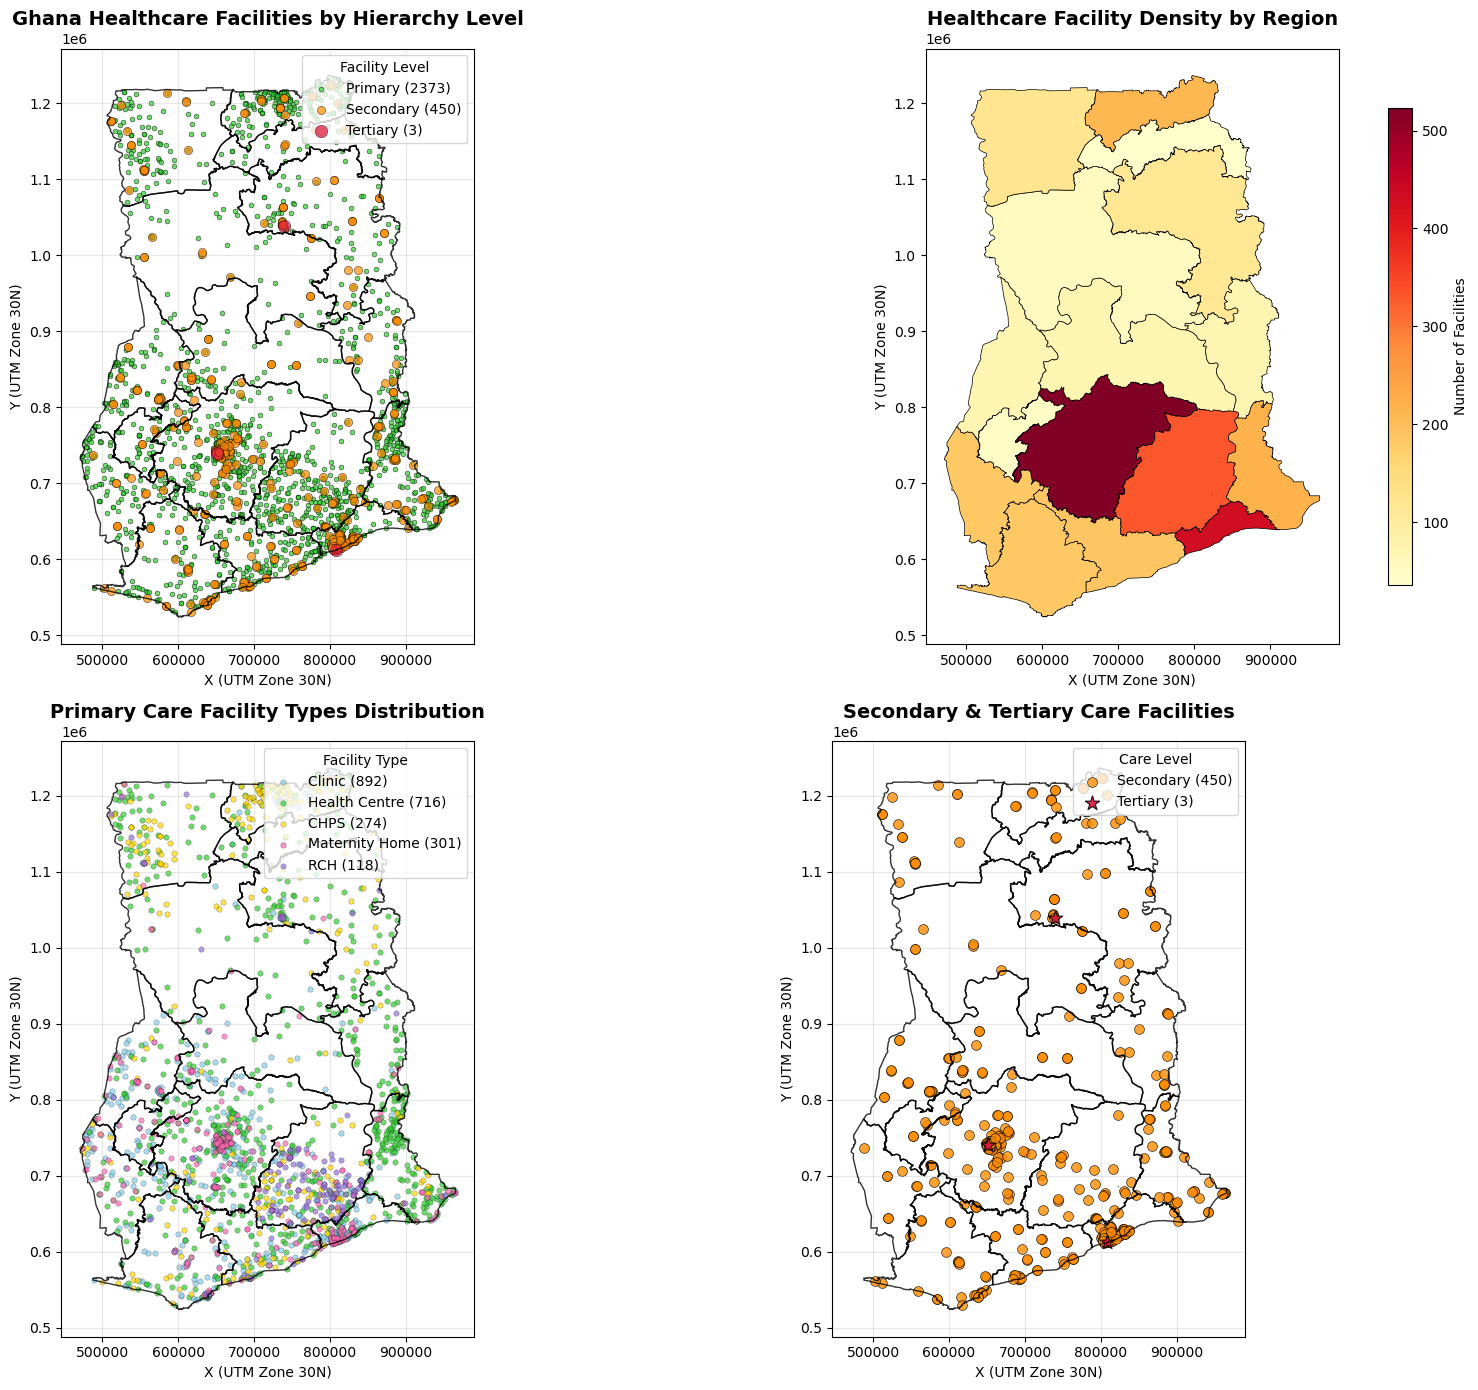

✅ Comprehensive healthcare facility maps created!
   • Total facilities mapped: 2826
   • Primary care: 2373
   • Secondary care: 450
   • Tertiary care: 3

📊 CREATING POPULATION-HEALTHCARE OVERLAY (UTM)...


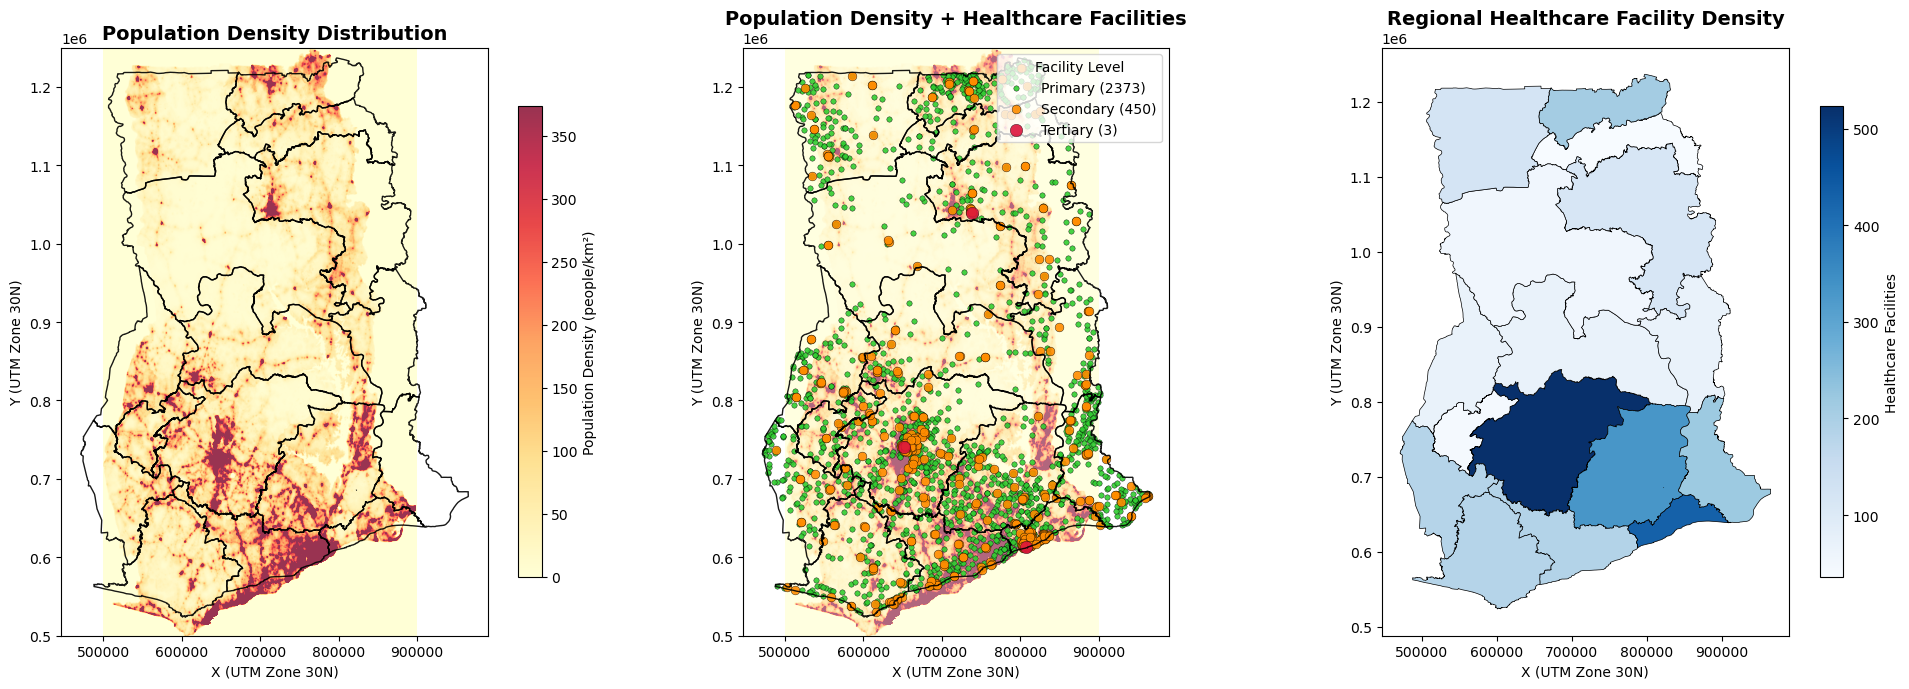

✅ Population-healthcare overlay maps created!

✅ SECTION 5: VISUAL PATTERN RECOGNITION COMPLETE!

🎯 COMPREHENSIVE SPATIAL VISUALIZATIONS CREATED:
   • Healthcare facility hierarchy maps
   • Regional facility density analysis
   • Primary care type distribution
   • Secondary/tertiary care mapping
   • Population-healthcare overlay analysis

🚀 READY FOR SECTION 6: STATISTICAL SUMMARIES AND CORRELATIONS


In [29]:
# =============================================================================
# SECTION 5: FINAL UTM-BASED VISUALIZATIONS
# Using UTM coordinates (x_utm, y_utm) for perfect alignment
# =============================================================================

print(f"\n" + "="*70)
print("SECTION 5: VISUAL PATTERN RECOGNITION (UTM COORDINATES)")
print("="*70)

def create_final_healthcare_maps_utm(hospitals_utm, regions_utm):
    """
    Create comprehensive healthcare facility maps using UTM coordinates
    """
    
    print(f"\n🗺️ CREATING FINAL HEALTHCARE FACILITY MAPS (UTM)...")
    
    # Add hierarchy classification to hospitals_utm if missing
    working_data = hospitals_utm.copy()
    
    if 'hierarchy_level' not in working_data.columns:
        print(f"   Adding hierarchy classification...")
        working_data['hierarchy_level'] = 'Primary'  # Default
        
        # Secondary level
        secondary_types = ['Hospital', 'District Hospital', 'Regional Hospital', 'Municipal Hospital', 
                          'Metropolitan Hospital', 'Psychiatric Hospital', 'Polyclinic',
                          'Regional Health Directorate', 'District Health Directorate', 
                          'Municipal Health Directorate', 'Metropolitan Health Directorate']
        working_data.loc[working_data['Type'].isin(secondary_types), 'hierarchy_level'] = 'Secondary'
        
        # Tertiary level
        tertiary_types = ['Teaching Hospital']
        working_data.loc[working_data['Type'].isin(tertiary_types), 'hierarchy_level'] = 'Tertiary'
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Define colors and sizes
    hierarchy_colors = {
        'Primary': '#32CD32',      # Green
        'Secondary': '#FF8C00',    # Orange  
        'Tertiary': '#DC143C'      # Red
    }
    
    hierarchy_sizes = {
        'Primary': 12,
        'Secondary': 35,
        'Tertiary': 80
    }
    
    # Map 1: All facilities by hierarchy level
    ax1 = axes[0, 0]
    regions_utm.boundary.plot(ax=ax1, color='black', linewidth=1, alpha=0.8)
    
    for level in ['Primary', 'Secondary', 'Tertiary']:
        level_facilities = working_data[working_data['hierarchy_level'] == level]
        
        if len(level_facilities) > 0:
            ax1.scatter(
                level_facilities['x_utm'], 
                level_facilities['y_utm'],
                c=hierarchy_colors[level], 
                s=hierarchy_sizes[level],
                alpha=0.7, 
                label=f'{level} ({len(level_facilities)})',
                edgecolors='black', 
                linewidth=0.4
            )
    
    ax1.set_title('Ghana Healthcare Facilities by Hierarchy Level', fontweight='bold', fontsize=14)
    ax1.legend(title='Facility Level', loc='upper right')
    ax1.set_xlabel('X (UTM Zone 30N)')
    ax1.set_ylabel('Y (UTM Zone 30N)')
    ax1.grid(True, alpha=0.3)
    
    # Map 2: Regional facility density (choropleth)
    ax2 = axes[0, 1]
    
    # Calculate facility counts by region with region name matching
    regional_counts = {}
    for region_name in regions_utm['NAME_1'].unique():
        # Try direct match and common variations
        count = 0
        for hospital_region in working_data['Region'].unique():
            if (region_name.lower() in hospital_region.lower() or 
                hospital_region.lower() in region_name.lower() or
                region_name == hospital_region):
                count += len(working_data[working_data['Region'] == hospital_region])
                break
        
        regional_counts[region_name] = count
    
    # Add facility counts to regions
    regions_utm['facility_count'] = regions_utm['NAME_1'].map(regional_counts)
    
    # Create choropleth map
    regions_utm.plot(
        column='facility_count', 
        ax=ax2, 
        cmap='YlOrRd', 
        legend=True,
        legend_kwds={'label': 'Number of Facilities', 'shrink': 0.8},
        edgecolor='black',
        linewidth=0.5
    )
    
    ax2.set_title('Healthcare Facility Density by Region', fontweight='bold', fontsize=14)
    ax2.set_xlabel('X (UTM Zone 30N)')
    ax2.set_ylabel('Y (UTM Zone 30N)')
    
    # Map 3: Primary care facility distribution
    ax3 = axes[1, 0]
    regions_utm.boundary.plot(ax=ax3, color='black', linewidth=1, alpha=0.8)
    
    primary_facilities = working_data[working_data['hierarchy_level'] == 'Primary']
    
    # Plot different primary care types
    primary_type_colors = {
        'Clinic': '#87CEEB',
        'Health Centre': '#32CD32', 
        'CHPS': '#FFD700',
        'Maternity Home': '#FF69B4',
        'RCH': '#9370DB'
    }
    
    for ptype, color in primary_type_colors.items():
        type_facilities = primary_facilities[primary_facilities['Type'] == ptype]
        
        if len(type_facilities) > 0:
            ax3.scatter(
                type_facilities['x_utm'], 
                type_facilities['y_utm'],
                c=color, 
                s=15,
                alpha=0.7, 
                label=f'{ptype} ({len(type_facilities)})',
                edgecolors='black', 
                linewidth=0.2
            )
    
    ax3.set_title('Primary Care Facility Types Distribution', fontweight='bold', fontsize=14)
    ax3.legend(title='Facility Type', loc='upper right', fontsize=10)
    ax3.set_xlabel('X (UTM Zone 30N)')
    ax3.set_ylabel('Y (UTM Zone 30N)')
    ax3.grid(True, alpha=0.3)
    
    # Map 4: Secondary and tertiary facilities with service areas
    ax4 = axes[1, 1]
    regions_utm.boundary.plot(ax=ax4, color='black', linewidth=1, alpha=0.8)
    
    # Plot secondary facilities
    secondary_facilities = working_data[working_data['hierarchy_level'] == 'Secondary']
    if len(secondary_facilities) > 0:
        ax4.scatter(
            secondary_facilities['x_utm'], 
            secondary_facilities['y_utm'],
            c=hierarchy_colors['Secondary'], 
            s=50,
            alpha=0.8, 
            label=f'Secondary ({len(secondary_facilities)})',
            edgecolors='black', 
            linewidth=0.5
        )
    
    # Plot tertiary facilities with star markers
    tertiary_facilities = working_data[working_data['hierarchy_level'] == 'Tertiary']
    if len(tertiary_facilities) > 0:
        ax4.scatter(
            tertiary_facilities['x_utm'], 
            tertiary_facilities['y_utm'],
            c=hierarchy_colors['Tertiary'], 
            s=120,
            alpha=0.9, 
            label=f'Tertiary ({len(tertiary_facilities)})',
            edgecolors='black', 
            linewidth=0.8,
            marker='*'
        )
    
    ax4.set_title('Secondary & Tertiary Care Facilities', fontweight='bold', fontsize=14)
    ax4.legend(title='Care Level', loc='upper right')
    ax4.set_xlabel('X (UTM Zone 30N)')
    ax4.set_ylabel('Y (UTM Zone 30N)')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Comprehensive healthcare facility maps created!")
    print(f"   • Total facilities mapped: {len(working_data)}")
    print(f"   • Primary care: {len(working_data[working_data['hierarchy_level'] == 'Primary'])}")
    print(f"   • Secondary care: {len(working_data[working_data['hierarchy_level'] == 'Secondary'])}")
    print(f"   • Tertiary care: {len(working_data[working_data['hierarchy_level'] == 'Tertiary'])}")
    
    return working_data

# Create final healthcare maps
final_hospital_data = create_final_healthcare_maps_utm(hospitals_utm, regions_utm)

# =============================================================================
# POPULATION + HEALTHCARE OVERLAY (UTM)
# =============================================================================

def create_population_healthcare_overlay_utm(hospital_data, pop_data_utm, regions_utm):
    """
    Create population density + healthcare facility overlay using UTM
    """
    
    print(f"\n📊 CREATING POPULATION-HEALTHCARE OVERLAY (UTM)...")
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    # Map 1: Population density only
    ax1 = axes[0]
    
    # Display population data
    pop_display = np.where(np.isnan(pop_data_utm), 0, pop_data_utm)
    im1 = ax1.imshow(
        pop_display, 
        cmap='YlOrRd', 
        alpha=0.8,
        vmin=0,
        vmax=np.percentile(pop_display[pop_display > 0], 95),
        extent=[500000, 900000, 500000, 1250000]  # Approximate UTM bounds for Ghana
    )
    
    plt.colorbar(im1, ax=ax1, label='Population Density (people/km²)', shrink=0.8)
    regions_utm.boundary.plot(ax=ax1, color='black', linewidth=1, alpha=0.9)
    
    ax1.set_title('Population Density Distribution', fontweight='bold', fontsize=14)
    ax1.set_xlabel('X (UTM Zone 30N)')
    ax1.set_ylabel('Y (UTM Zone 30N)')
    
    # Map 2: Population + Healthcare facilities overlay
    ax2 = axes[1]
    
    # Population background
    im2 = ax2.imshow(
        pop_display, 
        cmap='YlOrRd', 
        alpha=0.6,
        vmin=0,
        vmax=np.percentile(pop_display[pop_display > 0], 95),
        extent=[500000, 900000, 500000, 1250000]
    )
    
    # Add facilities by hierarchy
    colors = {'Primary': '#32CD32', 'Secondary': '#FF8C00', 'Tertiary': '#DC143C'}
    sizes = {'Primary': 15, 'Secondary': 40, 'Tertiary': 80}
    
    for level in ['Primary', 'Secondary', 'Tertiary']:
        level_facilities = hospital_data[hospital_data['hierarchy_level'] == level]
        
        if len(level_facilities) > 0:
            ax2.scatter(
                level_facilities['x_utm'], 
                level_facilities['y_utm'],
                c=colors[level], 
                s=sizes[level],
                alpha=0.9, 
                label=f'{level} ({len(level_facilities)})',
                edgecolors='black', 
                linewidth=0.3
            )
    
    regions_utm.boundary.plot(ax=ax2, color='black', linewidth=1, alpha=0.9)
    ax2.set_title('Population Density + Healthcare Facilities', fontweight='bold', fontsize=14)
    ax2.legend(title='Facility Level', loc='upper right')
    ax2.set_xlabel('X (UTM Zone 30N)')
    ax2.set_ylabel('Y (UTM Zone 30N)')
    
    # Map 3: Regional healthcare density summary
    ax3 = axes[2]
    
    regions_utm.plot(
        column='facility_count', 
        ax=ax3, 
        cmap='Blues', 
        legend=True,
        legend_kwds={'label': 'Healthcare Facilities', 'shrink': 0.8},
        edgecolor='black',
        linewidth=0.5
    )
    
    ax3.set_title('Regional Healthcare Facility Density', fontweight='bold', fontsize=14)
    ax3.set_xlabel('X (UTM Zone 30N)')
    ax3.set_ylabel('Y (UTM Zone 30N)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Population-healthcare overlay maps created!")
    
    return True

# Create population-healthcare overlay
create_population_healthcare_overlay_utm(final_hospital_data, pop_data_utm, regions_utm)

print(f"\n" + "="*70)
print("✅ SECTION 5: VISUAL PATTERN RECOGNITION COMPLETE!")
print("="*70)
print(f"\n🎯 COMPREHENSIVE SPATIAL VISUALIZATIONS CREATED:")
print(f"   • Healthcare facility hierarchy maps")
print(f"   • Regional facility density analysis") 
print(f"   • Primary care type distribution")
print(f"   • Secondary/tertiary care mapping")
print(f"   • Population-healthcare overlay analysis")

print(f"\n🚀 READY FOR SECTION 6: STATISTICAL SUMMARIES AND CORRELATIONS")

In [33]:
# =============================================================================
# EDA EXPORT CHECKLIST FOR GOOGLE COLAB
# Save essential datasets and results for accessibility analysis
# =============================================================================

print("📦 PREPARING EDA RESULTS FOR GOOGLE COLAB EXPORT...")

# =============================================================================
# 1. HEALTHCARE FACILITIES DATA (Most Important)
# =============================================================================

print("\n🏥 EXPORTING HEALTHCARE FACILITIES DATA:")

# Use the working hospital data with UTM coordinates
hospitals_for_export = hospitals_utm.copy()

# Add hierarchy classification if missing
if 'hierarchy_level' not in hospitals_for_export.columns:
    print("   Adding hierarchy classification...")
    hospitals_for_export['hierarchy_level'] = 'Primary'  # Default
    
    # Secondary level facilities
    secondary_types = ['Hospital', 'District Hospital', 'Regional Hospital', 'Municipal Hospital', 
                      'Metropolitan Hospital', 'Psychiatric Hospital', 'Polyclinic',
                      'Regional Health Directorate', 'District Health Directorate', 
                      'Municipal Health Directorate', 'Metropolitan Health Directorate']
    hospitals_for_export.loc[hospitals_for_export['Type'].isin(secondary_types), 'hierarchy_level'] = 'Secondary'
    
    # Tertiary level facilities  
    tertiary_types = ['Teaching Hospital']
    hospitals_for_export.loc[hospitals_for_export['Type'].isin(tertiary_types), 'hierarchy_level'] = 'Tertiary'

# Add capacity weights for gravity model
capacity_weights = {'Primary': 1.0, 'Secondary': 3.0, 'Tertiary': 10.0}
hospitals_for_export['capacity_weight'] = hospitals_for_export['hierarchy_level'].map(capacity_weights)

# Keep essential columns only
essential_facility_cols = [
    'OBJECTID', 'Region', 'District', 'FacilityNa', 'Type', 'Ownership',
    'latitude', 'longitude', 'x_utm', 'y_utm', 
    'hierarchy_level', 'capacity_weight'
]

# Filter to available columns
available_cols = [col for col in essential_facility_cols if col in hospitals_for_export.columns]
hospitals_clean_export = hospitals_for_export[available_cols].copy()

print(f"   ✅ Healthcare facilities ready: {len(hospitals_clean_export)} facilities")
print(f"   ✅ Columns included: {available_cols}")

# Export to CSV
hospitals_clean_export.to_csv('healthcare_facilities_for_colab.csv', index=False)
print(f"   💾 Saved: 'healthcare_facilities_for_colab.csv'")

# =============================================================================
# 2. POPULATION DATA (Raster)
# =============================================================================

print(f"\n👥 EXPORTING POPULATION DATA:")

# Save population raster as numpy array
import numpy as np

# Clean population data (replace NaN with 0 for easier processing)
pop_data_clean = np.where(np.isnan(pop_data_utm), 0, pop_data_utm)

print(f"   ✅ Population grid shape: {pop_data_clean.shape}")
print(f"   ✅ Population range: {pop_data_clean.min()} to {pop_data_clean.max()}")
print(f"   ✅ Non-zero pixels: {np.sum(pop_data_clean > 0):,}")

# Save as compressed numpy array
np.savez_compressed('population_data_for_colab.npz', 
                   population_grid=pop_data_clean)
print(f"   💾 Saved: 'population_data_for_colab.npz'")

# =============================================================================
# 3. MALARIA DATA (Optional)
# =============================================================================

print(f"\n🦟 EXPORTING MALARIA DATA:")

if 'malaria_data_utm' in globals():
    malaria_data_clean = np.where(np.isnan(malaria_data_utm), 0, malaria_data_utm)
    
    print(f"   ✅ Malaria grid shape: {malaria_data_clean.shape}")
    print(f"   ✅ Malaria range: {malaria_data_clean.min():.3f} to {malaria_data_clean.max():.3f}")
    
    np.savez_compressed('malaria_data_for_colab.npz', 
                       malaria_grid=malaria_data_clean)
    print(f"   💾 Saved: 'malaria_data_for_colab.npz'")
else:
    print(f"   ⚠️  Malaria data not available")

# =============================================================================
# 4. ADMINISTRATIVE BOUNDARIES
# =============================================================================

print(f"\n🗺️  EXPORTING ADMINISTRATIVE BOUNDARIES:")

# Save boundary data as GeoJSON (easier to load in Colab)
regions_utm.to_file('ghana_regions_utm.geojson', driver='GeoJSON')
print(f"   💾 Saved: 'ghana_regions_utm.geojson'")

# =============================================================================
# 5. SUMMARY STATISTICS AND METADATA
# =============================================================================

print(f"\n📊 EXPORTING SUMMARY METADATA:")

# Create metadata dictionary
metadata = {
    'dataset_info': {
        'total_facilities': len(hospitals_clean_export),
        'population_pixels': int(np.sum(pop_data_clean > 0)),
        'total_population': int(pop_data_clean.sum()),
        'coordinate_system': 'UTM Zone 30N (EPSG:32630)',
        'grid_resolution': '1km x 1km',
        'data_year': '2020'
    },
    'facility_hierarchy': {
        'Primary': int(np.sum(hospitals_clean_export['hierarchy_level'] == 'Primary')),
        'Secondary': int(np.sum(hospitals_clean_export['hierarchy_level'] == 'Secondary')), 
        'Tertiary': int(np.sum(hospitals_clean_export['hierarchy_level'] == 'Tertiary'))
    },
    'capacity_weights': capacity_weights,
    'coordinate_ranges': {
        'x_utm_min': float(hospitals_clean_export['x_utm'].min()),
        'x_utm_max': float(hospitals_clean_export['x_utm'].max()),
        'y_utm_min': float(hospitals_clean_export['y_utm'].min()),
        'y_utm_max': float(hospitals_clean_export['y_utm'].max())
    }
}

# Save metadata as JSON
import json
with open('dataset_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"   💾 Saved: 'dataset_metadata.json'")

# =============================================================================
# 6. EXPORT SUMMARY
# =============================================================================

print(f"\n" + "="*60)
print("✅ EDA EXPORT COMPLETE - READY FOR GOOGLE COLAB!")
print("="*60)

print(f"\n📦 FILES TO UPLOAD TO GOOGLE COLAB:")
print(f"   1. 📋 healthcare_facilities_for_colab.csv ({len(hospitals_clean_export)} facilities)")
print(f"   2. 👥 population_data_for_colab.npz ({pop_data_clean.shape} grid)")
if 'malaria_data_utm' in globals():
    print(f"   3. 🦟 malaria_data_for_colab.npz ({malaria_data_clean.shape} grid)")
print(f"   4. 🗺️  ghana_regions_utm.geojson (administrative boundaries)")
print(f"   5. 📊 dataset_metadata.json (summary info)")

print(f"\n🚀 NEXT STEPS IN GOOGLE COLAB:")
print(f"   1. Upload these files to Colab")
print(f"   2. Load the data using provided loading code")
print(f"   3. Start accessibility analysis with gravity model")
print(f"   4. Implement P-median optimization")

print(f"\n💡 KEY ADVANTAGES FOR COLAB:")
print(f"   • More computational power for optimization")
print(f"   • Better handling of large distance matrices") 
print(f"   • Access to optimization libraries (OR-Tools, PuLP)")
print(f"   • Easier sharing and collaboration")

# =============================================================================
# 7. COLAB LOADING CODE TEMPLATE
# =============================================================================

colab_loading_code = '''
# =============================================================================
# GOOGLE COLAB DATA LOADING CODE
# =============================================================================

import pandas as pd
import numpy as np
import geopandas as gpd
import json

# Load healthcare facilities
hospitals = pd.read_csv('healthcare_facilities_for_colab.csv')
print(f"✅ Loaded {len(hospitals)} healthcare facilities")

# Load population data
pop_data = np.load('population_data_for_colab.npz')['population_grid']
print(f"✅ Loaded population grid: {pop_data.shape}")

# Load malaria data (if available)
try:
    malaria_data = np.load('malaria_data_for_colab.npz')['malaria_grid']
    print(f"✅ Loaded malaria grid: {malaria_data.shape}")
except:
    print("⚠️  Malaria data not available")

# Load boundaries
regions = gpd.read_file('ghana_regions_utm.geojson')
print(f"✅ Loaded {len(regions)} administrative regions")

# Load metadata
with open('dataset_metadata.json', 'r') as f:
    metadata = json.load(f)
print(f"✅ Loaded dataset metadata")

print("\\n🚀 Ready for accessibility analysis!")
'''

# Save loading code template
with open('colab_data_loading_template.py', 'w') as f:
    f.write(colab_loading_code)

print(f"\n📝 BONUS: 'colab_data_loading_template.py' created")
print(f"   → Copy this code into your Colab notebook to load all data easily!")

📦 PREPARING EDA RESULTS FOR GOOGLE COLAB EXPORT...

🏥 EXPORTING HEALTHCARE FACILITIES DATA:
   Adding hierarchy classification...
   ✅ Healthcare facilities ready: 2826 facilities
   ✅ Columns included: ['OBJECTID', 'Region', 'District', 'FacilityNa', 'Type', 'Ownership', 'latitude', 'longitude', 'x_utm', 'y_utm', 'hierarchy_level', 'capacity_weight']
   💾 Saved: 'healthcare_facilities_for_colab.csv'

👥 EXPORTING POPULATION DATA:
   ✅ Population grid shape: (722, 500)
   ✅ Population range: 0.0 to 27293.107421875
   ✅ Non-zero pixels: 242,084
   💾 Saved: 'population_data_for_colab.npz'

🦟 EXPORTING MALARIA DATA:
   ✅ Malaria grid shape: (722, 500)
   ✅ Malaria range: 0.000 to 0.438
   💾 Saved: 'malaria_data_for_colab.npz'

🗺️  EXPORTING ADMINISTRATIVE BOUNDARIES:
   💾 Saved: 'ghana_regions_utm.geojson'

📊 EXPORTING SUMMARY METADATA:
   💾 Saved: 'dataset_metadata.json'

✅ EDA EXPORT COMPLETE - READY FOR GOOGLE COLAB!

📦 FILES TO UPLOAD TO GOOGLE COLAB:
   1. 📋 healthcare_facilities_for_